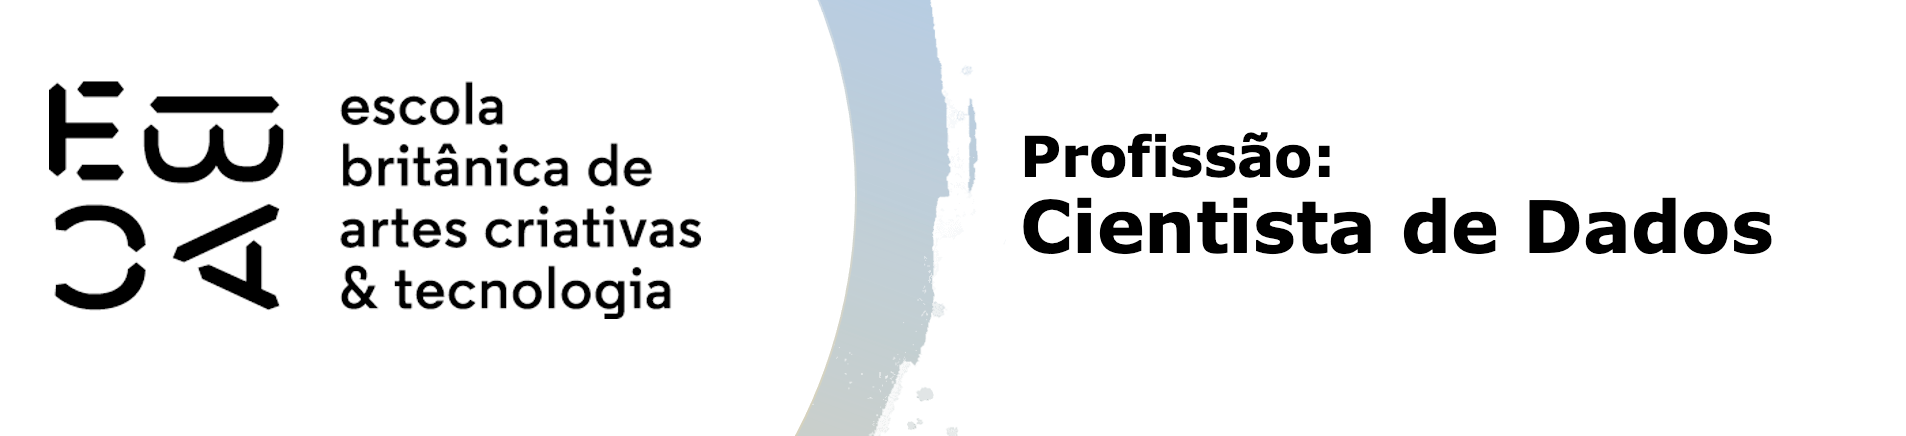

# Tarefa II

Neste projeto, estamos construindo um credit scoring para cartão de crédito, em um desenho amostral com 15 safras, e utilizando 12 meses de performance.

Carregue a base de dados ```credit_scoring.ftr```.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.formula.api as smf
import statsmodels.api as sm

from sklearn import metrics
from scipy.stats import ks_2samp
from scipy.stats import t

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
# from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import FunctionTransformer

from sklearn.pipeline import Pipeline

import pickle

In [2]:
df = pd.read_feather('credit_scoring.ftr')
df.head()

,data_ref,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,mau
0,2015-01-01,5733,F,N,N,0,Empresário,Médio,Solteiro,Casa,43,6.873973,1.0,2515.39,False
1,2015-01-01,727,F,S,S,0,Assalariado,Médio,Casado,Casa,35,4.526027,2.0,3180.19,False
2,2015-01-01,6374,F,N,N,2,Assalariado,Médio,Casado,Casa,31,0.243836,4.0,1582.29,False
3,2015-01-01,9566,F,N,N,0,Assalariado,Médio,Casado,Casa,54,12.772603,2.0,13721.17,False
4,2015-01-01,9502,F,S,N,0,Assalariado,Superior incompleto,Solteiro,Casa,31,8.432877,1.0,2891.08,False


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750000 entries, 0 to 749999
Data columns (total 15 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   data_ref               750000 non-null  datetime64[ns]
 1   index                  750000 non-null  int64         
 2   sexo                   750000 non-null  object        
 3   posse_de_veiculo       750000 non-null  object        
 4   posse_de_imovel        750000 non-null  object        
 5   qtd_filhos             750000 non-null  int64         
 6   tipo_renda             750000 non-null  object        
 7   educacao               750000 non-null  object        
 8   estado_civil           750000 non-null  object        
 9   tipo_residencia        750000 non-null  object        
 10  idade                  750000 non-null  int64         
 11  tempo_emprego          624043 non-null  float64       
 12  qt_pessoas_residencia  750000 non-null  floa

In [4]:
df.describe()

,data_ref,index,qtd_filhos,idade,tempo_emprego,qt_pessoas_residencia,renda
count,750000,750000.000000,750000.000000,750000.000000,624043.000000,750000.000000,7.500000e+05
mean,2015-08-01 06:24:00,8319.272793,0.433251,43.804733,7.748574,2.212241,2.323854e+04
min,2015-01-01 00:00:00,0.000000,0.000000,22.000000,0.117808,1.000000,1.076700e+02
25%,2015-04-01 00:00:00,4147.000000,0.000000,34.000000,3.049315,2.000000,3.467700e+03
50%,2015-08-01 00:00:00,8324.000000,0.000000,43.000000,6.046575,2.000000,7.861820e+03
75%,2015-12-01 00:00:00,12487.000000,1.000000,53.000000,10.183562,3.000000,1.831828e+04
max,2016-03-01 00:00:00,16649.000000,14.000000,68.000000,42.906849,15.000000,4.083986e+06
std,NaN,4809.281774,0.739379,11.229868,6.687455,0.903428,7.910601e+04


In [5]:
df['tempo_emprego'].isna().sum()

125957

In [6]:
dados = df.groupby(by='idade')['tempo_emprego'].median()
dados

idade
22     2.961644
23     2.931507
24     2.630137
25     3.687671
26     3.350685
27     4.419178
28     4.693151
29     4.410959
30     5.328767
31     5.298630
32     5.523288
33     4.964384
34     5.767123
35     5.052055
36     6.964384
37     6.046575
38     6.586301
39     6.767123
40     6.747945
41     5.758904
42     7.298630
43     7.556164
44     6.934247
45     6.786301
46     5.550685
47     6.430137
48     6.712329
49     8.367123
50     7.556164
51     9.517808
52     8.358904
53     7.213699
54     8.846575
55     7.347945
56    10.610959
57     7.841096
58     7.473973
59     8.613699
60    14.287671
61     8.136986
62     7.619178
63     8.772603
64     7.169863
65     5.882192
66     8.372603
67    21.194521
68          NaN
Name: tempo_emprego, dtype: float64

In [7]:
for idade, tempo_emprego in dados.items():
    df.loc[(df['tempo_emprego'].isna()) & (df['idade'] == idade), 'tempo_emprego'] = tempo_emprego

In [8]:
df['tempo_emprego'].isna().sum()

855

In [9]:
df.loc[df['tempo_emprego'].isna(), 'tempo_emprego'] = df['tempo_emprego'].median()

In [10]:
df['tempo_emprego'].isna().sum()

0

## Amostragem

Separe os três últimos meses como safras de validação *out of time* (oot).

Variáveis:<br>
Considere que a variável ```data_ref``` não é uma variável explicativa, é somente uma variável indicadora da safra, e não deve ser utilizada na modelagem. A variávei ```index``` é um identificador do cliente, e também não deve ser utilizada como covariável (variável explicativa). As restantes podem ser utilizadas para prever a inadimplência, incluindo a renda.


In [11]:
df.drop(labels='index', axis=1, inplace=True)

In [12]:
df.set_index(keys=[df.index, pd.to_datetime(df['data_ref'])], inplace=True)
df.drop(labels='data_ref', axis=1, inplace=True)
df.sort_index(level=1, inplace=True)

In [13]:
end_date_validation = df[-1:].index[0][1]
start_date_validation = end_date_validation - pd.DateOffset(months=2)

start_date_train = df[:1].index[0][1]
end_date_train = (start_date_validation - pd.DateOffset(days=1)) - pd.offsets.MonthBegin(1)

print(f'Train start date: {start_date_train}')
print(f'Train end date: {end_date_train}')
print(f'Test start date: {start_date_validation}')
print(f'Test end date: {end_date_validation}')

df_train = df.loc[(slice(None), slice(start_date_train, end_date_train)), :].copy()
df_validation = df.loc[(slice(None), slice(start_date_validation, end_date_validation)), :].copy()

Train start date: 2015-01-01 00:00:00
Train end date: 2015-12-01 00:00:00
Test start date: 2016-01-01 00:00:00
Test end date: 2016-03-01 00:00:00


## Descritiva básica univariada

- Descreva a base quanto ao número de linhas, número de linhas para cada mês em ```data_ref```.
- Faça uma descritiva básica univariada de cada variável. Considere as naturezas diferentes: qualitativas e quantitativas.

In [14]:
len(df_train)

600000

In [15]:
df_train.index.get_level_values(level=1).month.value_counts()

data_ref
1     50000
2     50000
3     50000
4     50000
5     50000
6     50000
7     50000
8     50000
9     50000
10    50000
11    50000
12    50000
Name: count, dtype: int64

In [16]:
metadados = pd.DataFrame(df.dtypes, columns=['dtype'])
metadados['ausentes'] = df.isna().sum()
metadados['unicos'] = df.nunique()
metadados['quantitativa'] = 0
colunas_quantitativa = ['qtd_filhos', 'idade', 'tempo_emprego', 'qt_pessoas_residencia', 'renda']
metadados.loc[colunas_quantitativa, 'quantitativa'] = 1
metadados

,dtype,ausentes,unicos,quantitativa
sexo,object,0,2,0
posse_de_veiculo,object,0,2,0
posse_de_imovel,object,0,2,0
qtd_filhos,int64,0,8,1
tipo_renda,object,0,5,0
educacao,object,0,5,0
estado_civil,object,0,5,0
tipo_residencia,object,0,6,0
idade,int64,0,47,1
tempo_emprego,float64,0,3004,1


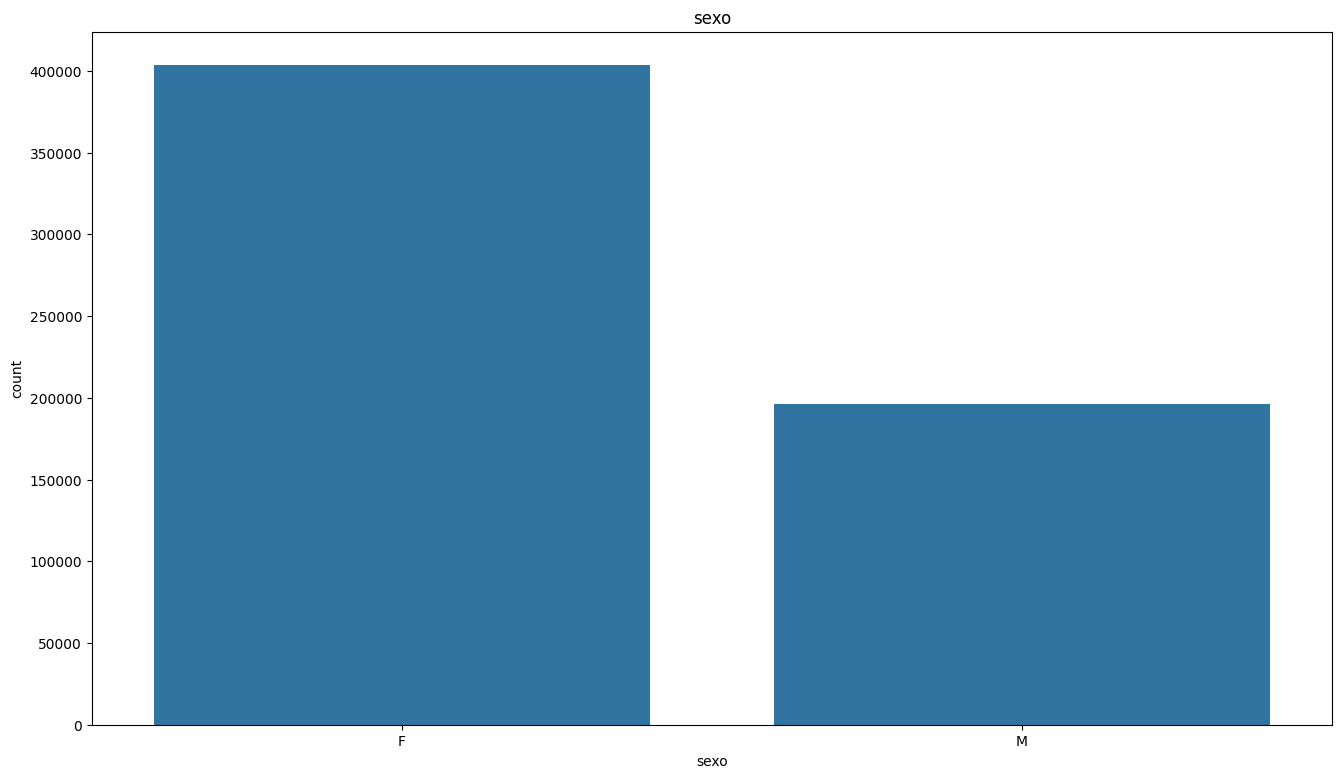

sexo
F    403805
M    196195
Name: count, dtype: int64

sexo
F    0.673008
M    0.326992
Name: proportion, dtype: float64

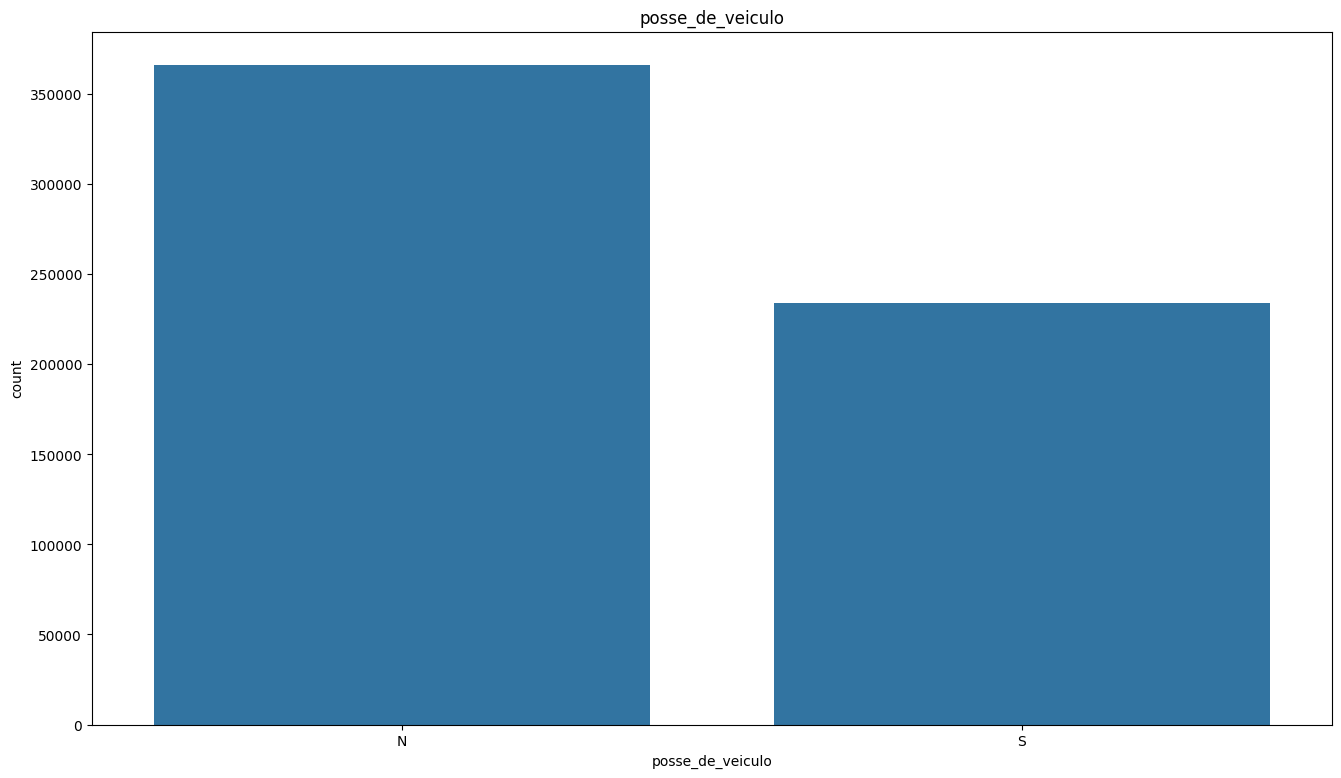

posse_de_veiculo
N    366293
S    233707
Name: count, dtype: int64

posse_de_veiculo
N    0.610488
S    0.389512
Name: proportion, dtype: float64

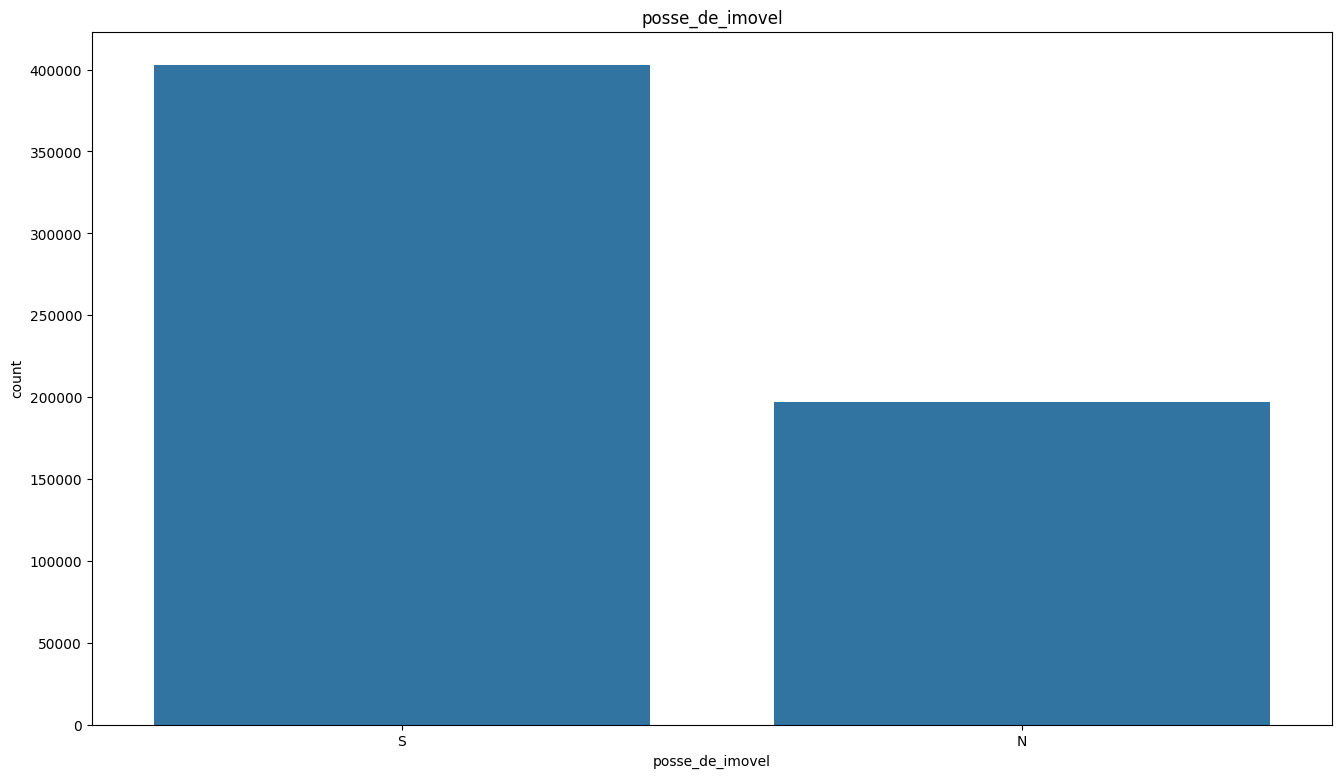

posse_de_imovel
S    403054
N    196946
Name: count, dtype: int64

posse_de_imovel
S    0.671757
N    0.328243
Name: proportion, dtype: float64

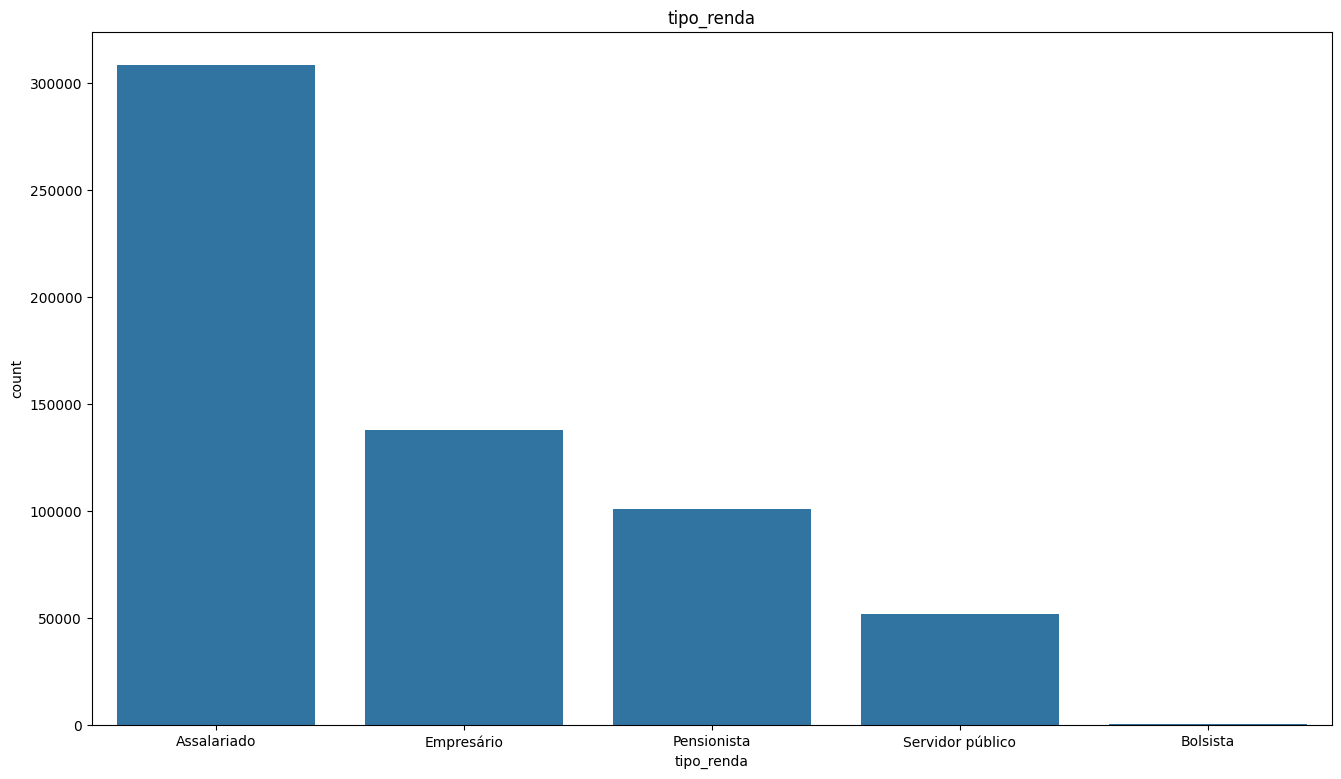

tipo_renda
Assalariado         308460
Empresário          138141
Pensionista         101127
Servidor público     51981
Bolsista               291
Name: count, dtype: int64

tipo_renda
Assalariado         0.514100
Empresário          0.230235
Pensionista         0.168545
Servidor público    0.086635
Bolsista            0.000485
Name: proportion, dtype: float64

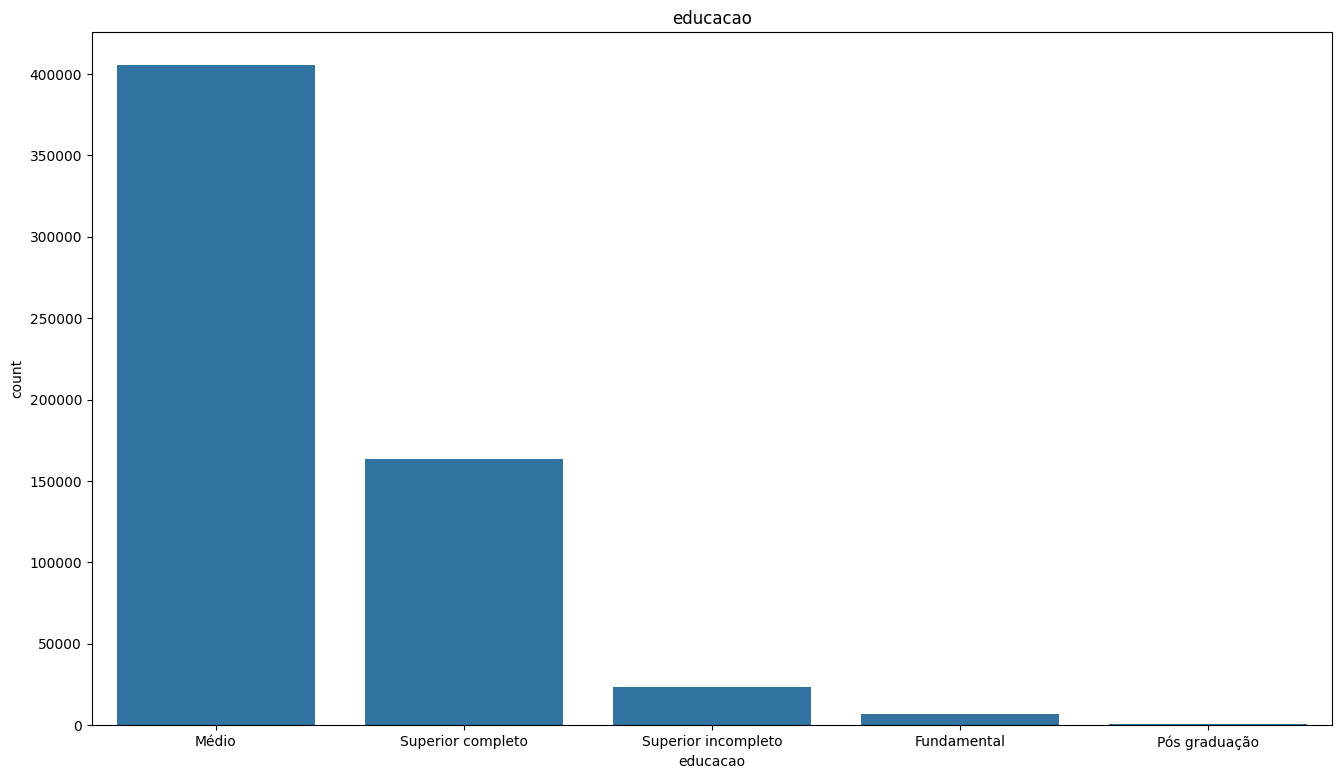

educacao
Médio                  405449
Superior completo      163440
Superior incompleto     23559
Fundamental              6901
Pós graduação             651
Name: count, dtype: int64

educacao
Médio                  0.675748
Superior completo      0.272400
Superior incompleto    0.039265
Fundamental            0.011502
Pós graduação          0.001085
Name: proportion, dtype: float64

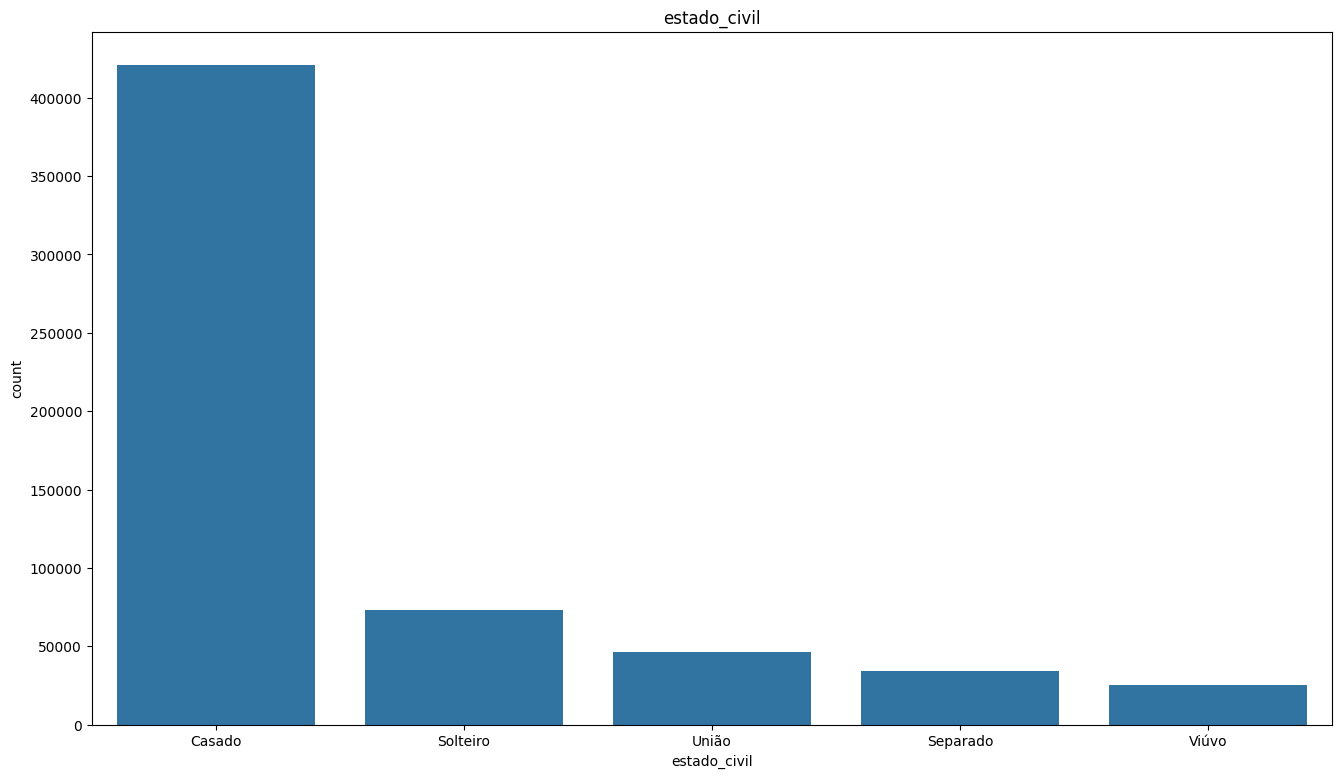

estado_civil
Casado      421149
Solteiro     73221
União        46108
Separado     34188
Viúvo        25334
Name: count, dtype: int64

estado_civil
Casado      0.701915
Solteiro    0.122035
União       0.076847
Separado    0.056980
Viúvo       0.042223
Name: proportion, dtype: float64

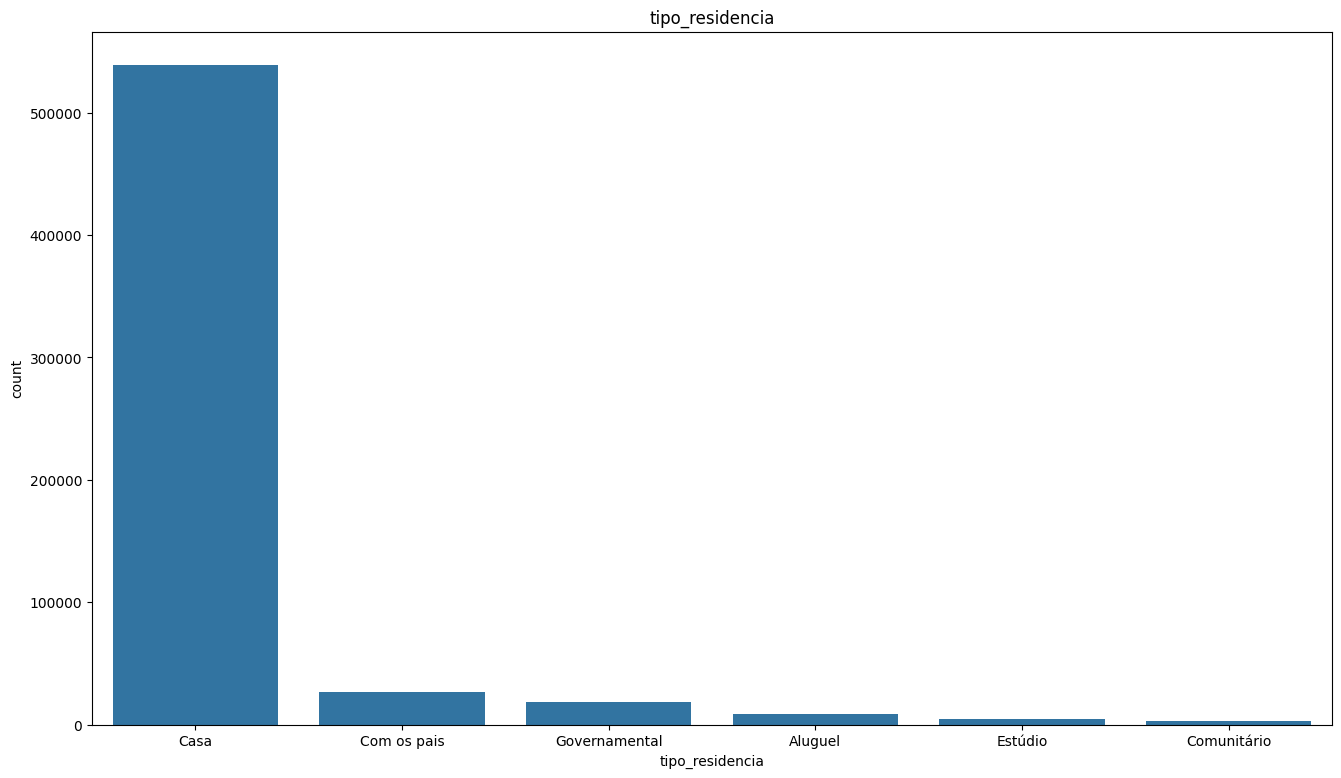

tipo_residencia
Casa             539336
Com os pais       26730
Governamental     18742
Aluguel            8262
Estúdio            4296
Comunitário        2634
Name: count, dtype: int64

tipo_residencia
Casa             0.898893
Com os pais      0.044550
Governamental    0.031237
Aluguel          0.013770
Estúdio          0.007160
Comunitário      0.004390
Name: proportion, dtype: float64

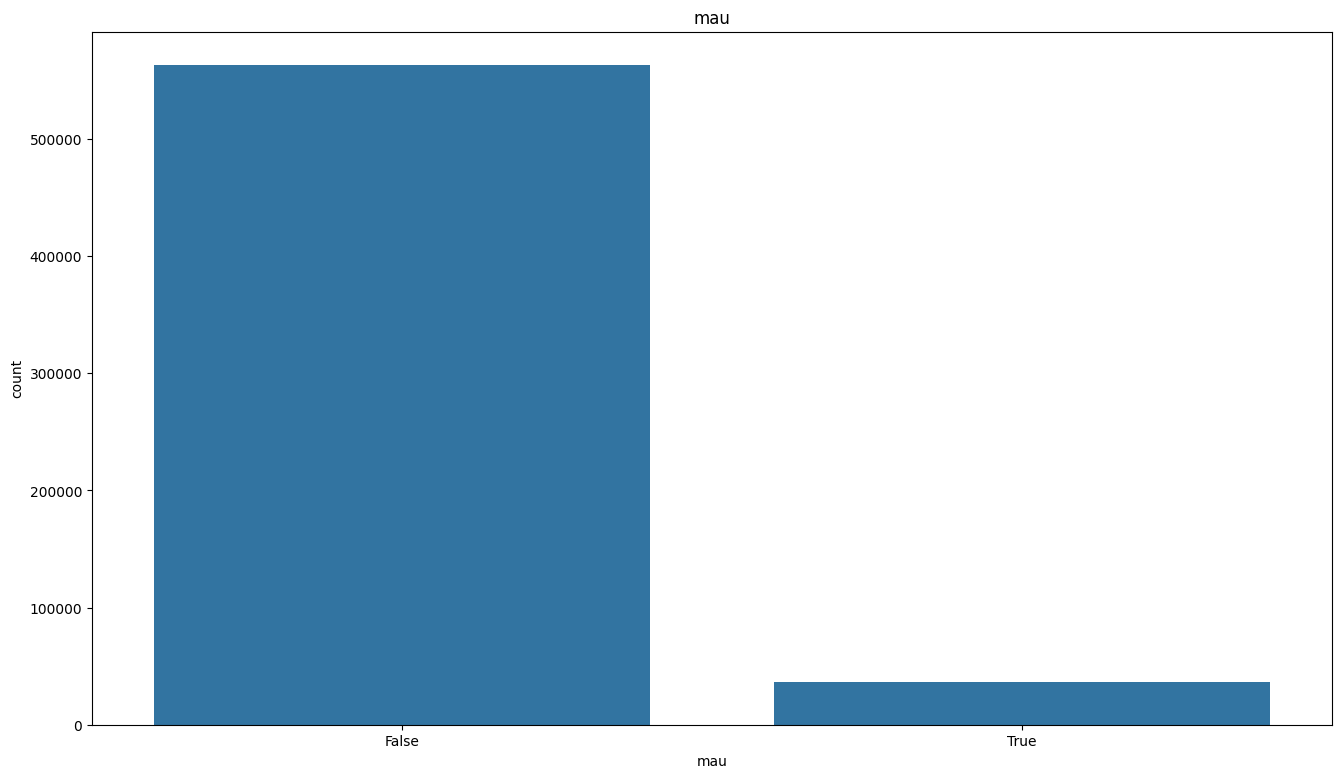

mau
False    563357
True      36643
Name: count, dtype: int64

mau
False    0.938928
True     0.061072
Name: proportion, dtype: float64

In [17]:
for column in metadados[metadados['quantitativa'] == 0].index:  
    plt.figure(figsize=(16,9))
    plt.title(label=column)
    sns.barplot(data=df_train[column].value_counts())
    plt.show()
    display(df_train[column].value_counts())
    display(df_train[column].value_counts(normalize=True))  

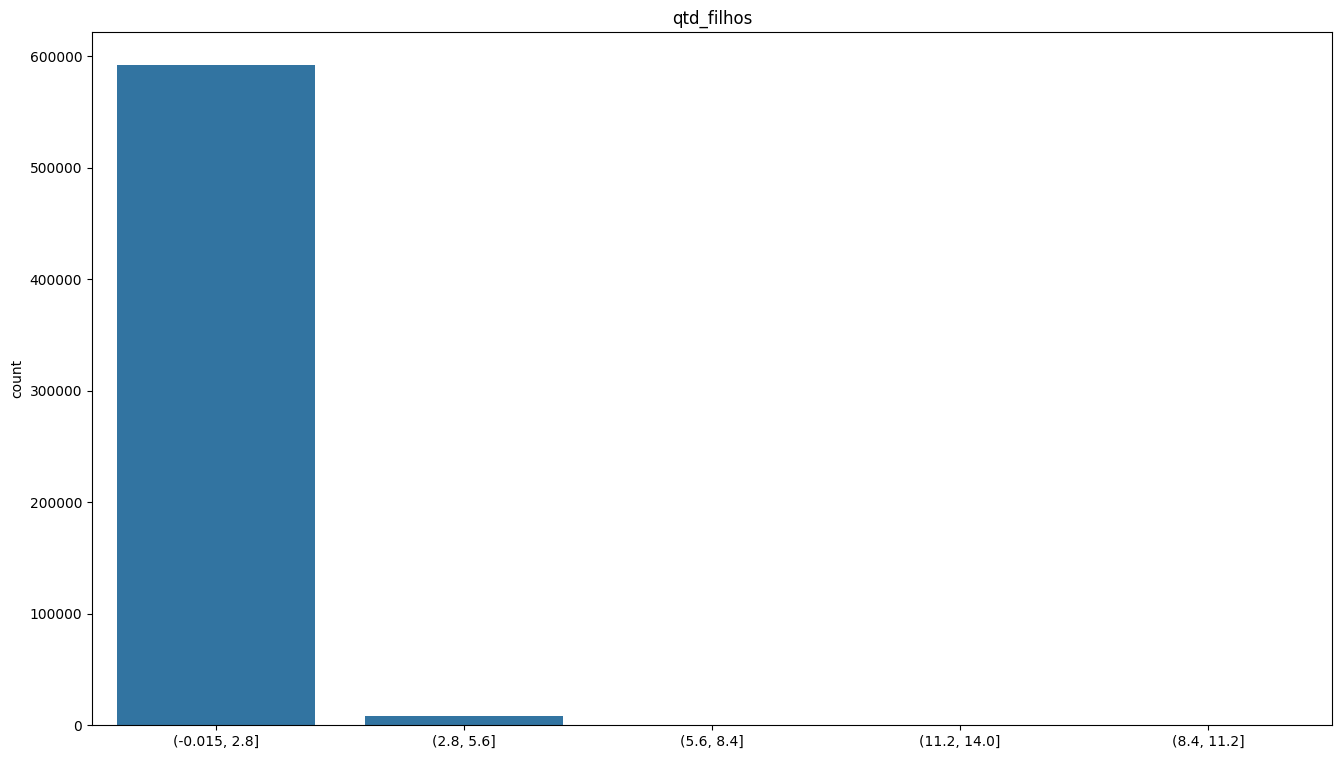

(-0.015, 2.8]    591956
(2.8, 5.6]         7891
(5.6, 8.4]           82
(11.2, 14.0]         71
(8.4, 11.2]           0
Name: count, dtype: int64

(-0.015, 2.8]    0.986593
(2.8, 5.6]       0.013152
(5.6, 8.4]       0.000137
(11.2, 14.0]     0.000118
(8.4, 11.2]      0.000000
Name: proportion, dtype: float64

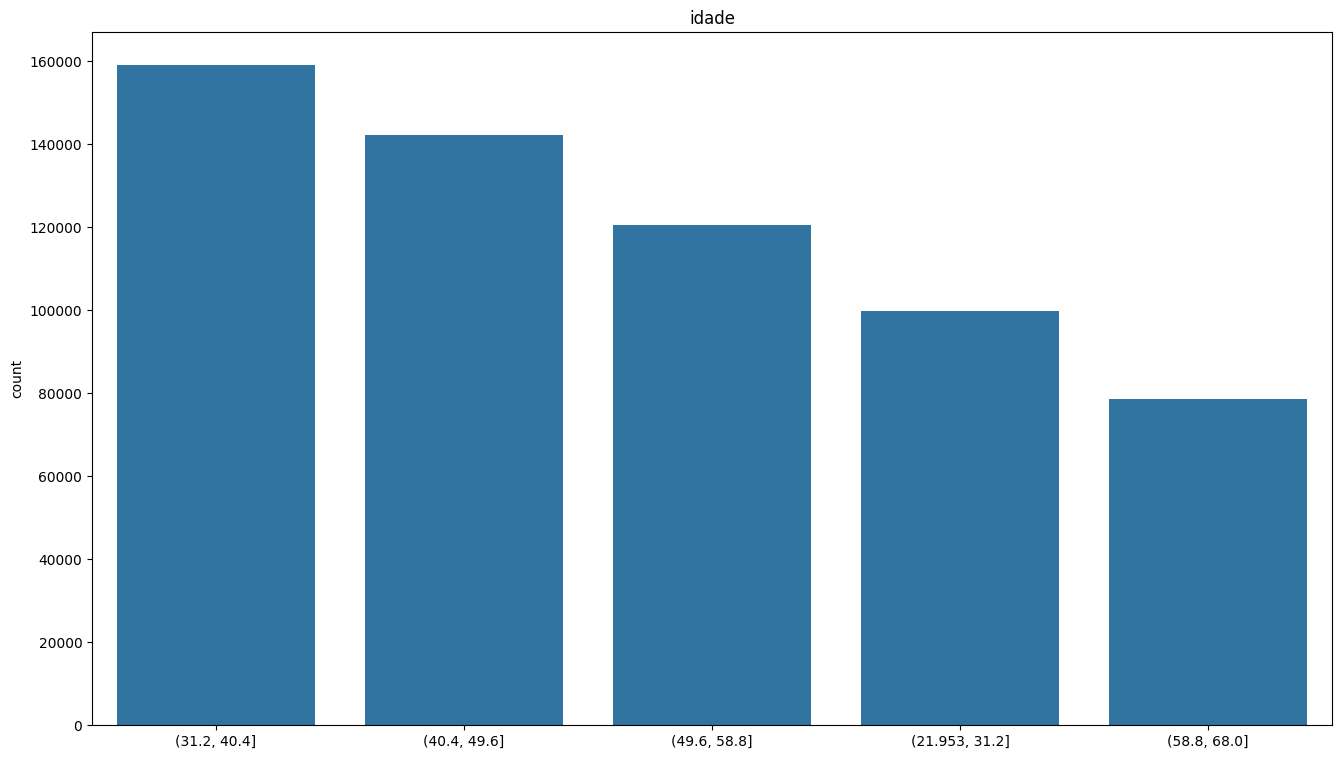

(31.2, 40.4]      159020
(40.4, 49.6]      142194
(49.6, 58.8]      120422
(21.953, 31.2]     99817
(58.8, 68.0]       78547
Name: count, dtype: int64

(31.2, 40.4]      0.265033
(40.4, 49.6]      0.236990
(49.6, 58.8]      0.200703
(21.953, 31.2]    0.166362
(58.8, 68.0]      0.130912
Name: proportion, dtype: float64

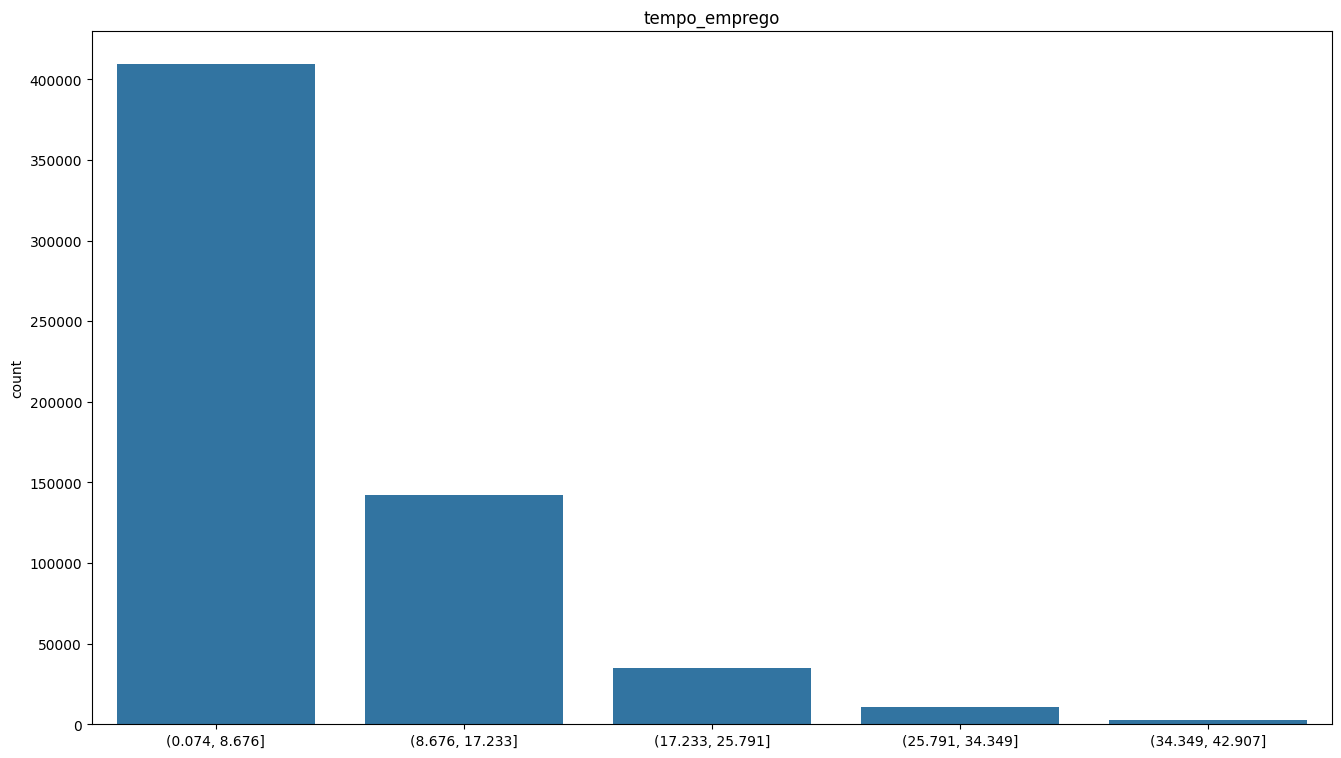

(0.074, 8.676]      409291
(8.676, 17.233]     142304
(17.233, 25.791]     34929
(25.791, 34.349]     10926
(34.349, 42.907]      2550
Name: count, dtype: int64

(0.074, 8.676]      0.682152
(8.676, 17.233]     0.237173
(17.233, 25.791]    0.058215
(25.791, 34.349]    0.018210
(34.349, 42.907]    0.004250
Name: proportion, dtype: float64

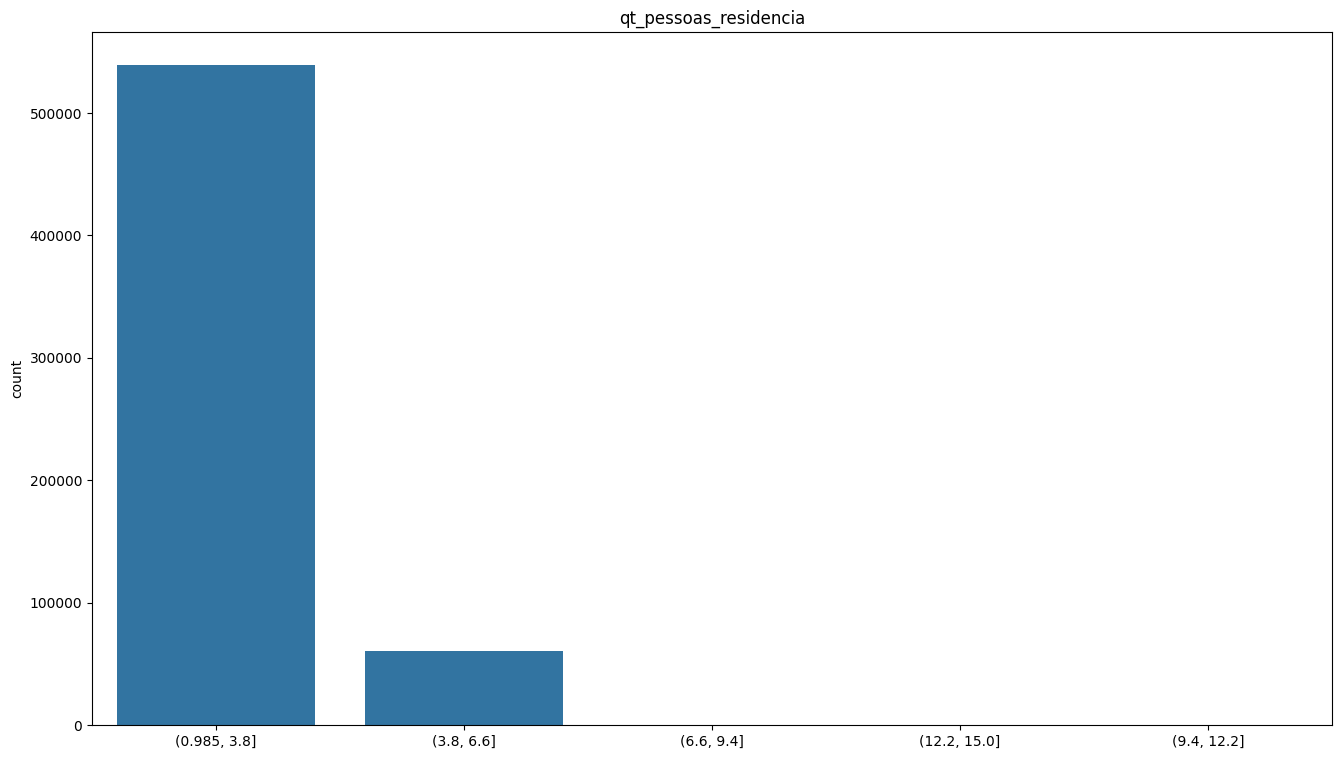

(0.985, 3.8]    538964
(3.8, 6.6]       60842
(6.6, 9.4]         123
(12.2, 15.0]        71
(9.4, 12.2]          0
Name: count, dtype: int64

(0.985, 3.8]    0.898273
(3.8, 6.6]      0.101403
(6.6, 9.4]      0.000205
(12.2, 15.0]    0.000118
(9.4, 12.2]     0.000000
Name: proportion, dtype: float64

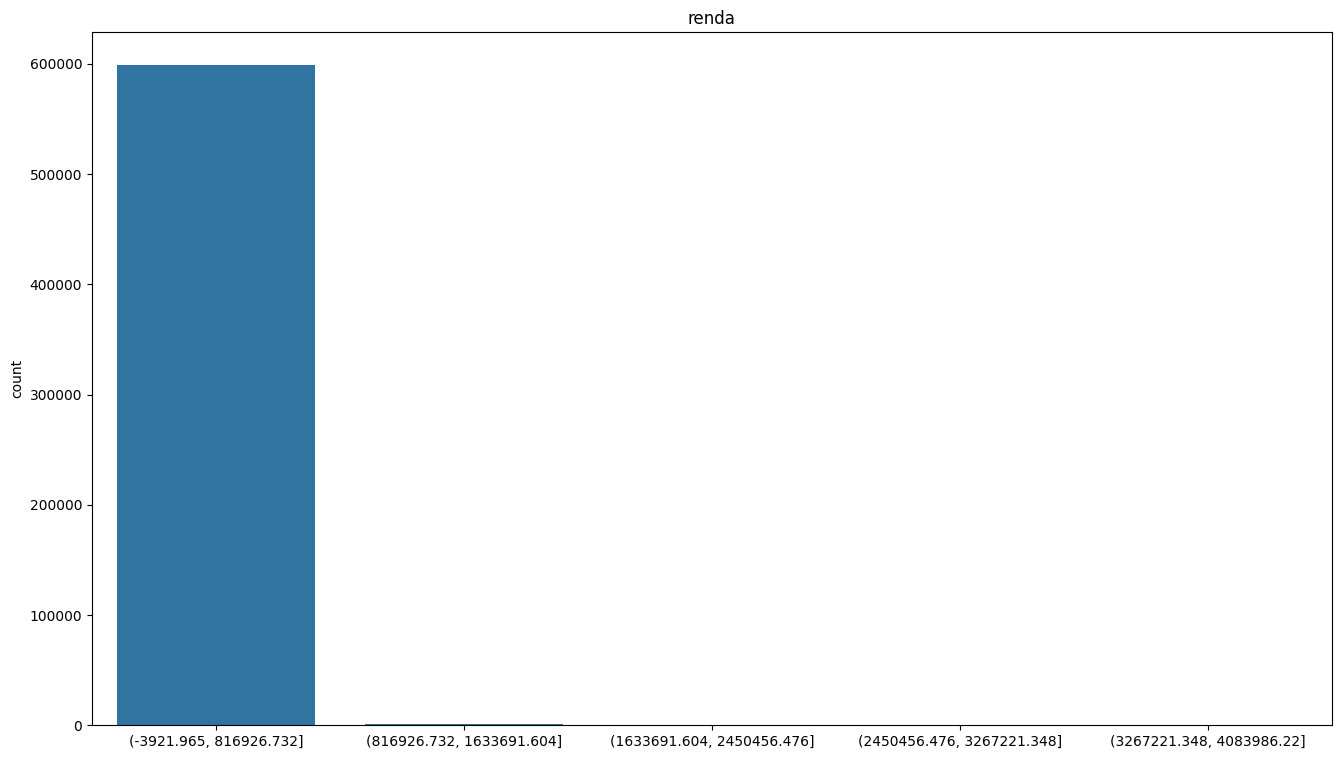

(-3921.965, 816926.732]       598739
(816926.732, 1633691.604]        978
(1633691.604, 2450456.476]       167
(2450456.476, 3267221.348]        95
(3267221.348, 4083986.22]         21
Name: count, dtype: int64

(-3921.965, 816926.732]       0.997898
(816926.732, 1633691.604]     0.001630
(1633691.604, 2450456.476]    0.000278
(2450456.476, 3267221.348]    0.000158
(3267221.348, 4083986.22]     0.000035
Name: proportion, dtype: float64

In [18]:
for column in metadados[metadados['quantitativa'] == 1].index:
    plt.figure(figsize=(16,9))
    plt.title(label=column)
    sns.barplot(data=df_train[column].value_counts(bins=5))
    plt.show()
    display(df_train[column].value_counts(bins=5))
    display(df_train[column].value_counts(bins=5, normalize=True))  

## Descritiva bivariada

Faça uma análise descritiva bivariada de cada variável

In [19]:
def cross_table(dataframe = None, independent = None, dependent = None, bins = 5):
    
    columns = dataframe.columns
    
    if independent not in columns or dependent not in columns:
        return None
    
    if dataframe[independent].nunique() > 6 and bins > 0:
        bin_name = f'{independent}_bin'
        dataframe[bin_name] = pd.cut(x = dataframe[independent], bins = bins, duplicates='drop')
        independent = bin_name
        
    cross_dataframe = pd.crosstab(
        index = dataframe[independent],
        columns = dataframe[dependent], 
        margins = True,
        margins_name = 'total'
    )
    
    total_normalize = (cross_dataframe['total'] / cross_dataframe.loc['total', 'total']) * 100
    
    mean = cross_dataframe.iloc[0:(cross_dataframe.shape[0] - 1), 1].mean()
    
    probability = cross_dataframe[1] / cross_dataframe['total']

    odds = cross_dataframe[1] / cross_dataframe[0]

    odds_ratio = (
        (cross_dataframe[1] / cross_dataframe.loc['total', 1]) /
        (cross_dataframe[0] / cross_dataframe.loc['total', 0])
    )

    logit = np.log(odds)

    woe = np.log(odds_ratio)

    cross_dataframe = cross_dataframe.assign(
        total_normalize = total_normalize,
        mean = mean, 
        probability = probability,
        odds = odds, 
        odds_ratio = odds_ratio, 
        logit = logit, 
        woe = woe
    )
    
    return cross_dataframe

In [20]:
columns = df_train.columns
for column in columns:
    cross_df = cross_table(dataframe = df_train, independent = column, dependent = 'mau')
    display(cross_df)

mau,False,True,total,total_normalize,mean,probability,odds,odds_ratio,logit,woe
sexo,,,,,,,,,,
F,378318,25487,403805,67.300833,18321.5,0.063117,0.067369,1.035749,-2.697567,0.035125
M,185039,11156,196195,32.699167,18321.5,0.056862,0.060290,0.926911,-2.808589,-0.075898
total,563357,36643,600000,100.000000,18321.5,0.061072,0.065044,1.000000,-2.732691,0.000000


mau,False,True,total,total_normalize,mean,probability,odds,odds_ratio,logit,woe
posse_de_veiculo,,,,,,,,,,
N,343778,22515,366293,61.048833,18321.5,0.061467,0.065493,1.006900,-2.725814,0.006877
S,219579,14128,233707,38.951167,18321.5,0.060452,0.064341,0.989196,-2.743553,-0.010862
total,563357,36643,600000,100.000000,18321.5,0.061072,0.065044,1.000000,-2.732691,0.000000


mau,False,True,total,total_normalize,mean,probability,odds,odds_ratio,logit,woe
posse_de_imovel,,,,,,,,,,
N,183305,13641,196946,32.824333,18321.5,0.069263,0.074417,1.144102,-2.598071,0.134620
S,380052,23002,403054,67.175667,18321.5,0.057069,0.060523,0.930498,-2.804727,-0.072036
total,563357,36643,600000,100.000000,18321.5,0.061072,0.065044,1.000000,-2.732691,0.000000


mau,False,True,total,total_normalize,mean,probability,odds,odds_ratio,logit,woe
qtd_filhos_bin,,,,,,,,,,
"(-0.014, 2.8]",555858,36098,591956,98.659333,9160.75,0.060981,0.064941,0.998417,-2.734275,-0.001584
"(2.8, 5.6]",7366,525,7891,1.315167,9160.75,0.066531,0.071273,1.095772,-2.641232,0.091459
"(5.6, 8.4]",69,13,82,0.013667,9160.75,0.158537,0.188406,2.896589,-1.669157,1.063534
"(11.2, 14.0]",64,7,71,0.011833,9160.75,0.098592,0.109375,1.681554,-2.212973,0.519718
total,563357,36643,600000,100.000000,9160.75,0.061072,0.065044,1.000000,-2.732691,0.000000


mau,False,True,total,total_normalize,mean,probability,odds,odds_ratio,logit,woe
tipo_renda,,,,,,,,,,
Assalariado,288865,19595,308460,51.4100,7328.6,0.063525,0.067834,1.042901,-2.690685,0.042006
Bolsista,279,12,291,0.0485,7328.6,0.041237,0.043011,0.661256,-3.146305,-0.413614
Empresário,129935,8206,138141,23.0235,7328.6,0.059403,0.063155,0.970953,-2.762169,-0.029478
Pensionista,94627,6500,101127,16.8545,7328.6,0.064276,0.068691,1.056066,-2.678141,0.054550
Servidor público,49651,2330,51981,8.6635,7328.6,0.044824,0.046928,0.721474,-3.059150,-0.326459
total,563357,36643,600000,100.0000,7328.6,0.061072,0.065044,1.000000,-2.732691,0.000000


mau,False,True,total,total_normalize,mean,probability,odds,odds_ratio,logit,woe
educacao,,,,,,,,,,
Fundamental,6420,481,6901,1.150167,7328.6,0.069700,0.074922,1.151868,-2.591306,0.141385
Médio,379939,25510,405449,67.574833,7328.6,0.062918,0.067142,1.032260,-2.700940,0.031751
Pós graduação,608,43,651,0.108500,7328.6,0.066052,0.070724,1.087320,-2.648975,0.083716
Superior completo,154354,9086,163440,27.240000,7328.6,0.055592,0.058865,0.904998,-2.832514,-0.099823
Superior incompleto,22036,1523,23559,3.926500,7328.6,0.064646,0.069114,1.062576,-2.671995,0.060696
total,563357,36643,600000,100.000000,7328.6,0.061072,0.065044,1.000000,-2.732691,0.000000


mau,False,True,total,total_normalize,mean,probability,odds,odds_ratio,logit,woe
estado_civil,,,,,,,,,,
Casado,395880,25269,421149,70.191500,7328.6,0.060000,0.063830,0.981335,-2.751533,-0.018842
Separado,31994,2194,34188,5.698000,7328.6,0.064175,0.068575,1.054292,-2.679822,0.052869
Solteiro,68585,4636,73221,12.203500,7328.6,0.063315,0.067595,1.039219,-2.694222,0.038469
União,43048,3060,46108,7.684667,7328.6,0.066366,0.071083,1.092851,-2.643901,0.088790
Viúvo,23850,1484,25334,4.222333,7328.6,0.058577,0.062222,0.956617,-2.777043,-0.044352
total,563357,36643,600000,100.000000,7328.6,0.061072,0.065044,1.000000,-2.732691,0.000000


mau,False,True,total,total_normalize,mean,probability,odds,odds_ratio,logit,woe
tipo_residencia,,,,,,,,,,
Aluguel,7666,596,8262,1.377000,6107.166667,0.072137,0.077746,1.195281,-2.554310,0.178382
Casa,506887,32449,539336,89.889333,6107.166667,0.060165,0.064016,0.984199,-2.748618,-0.015927
Com os pais,24733,1997,26730,4.455000,6107.166667,0.074710,0.080742,1.241349,-2.516492,0.216199
Comunitário,2449,185,2634,0.439000,6107.166667,0.070235,0.075541,1.161383,-2.583079,0.149612
Estúdio,4071,225,4296,0.716000,6107.166667,0.052374,0.055269,0.849717,-2.895544,-0.162852
Governamental,17551,1191,18742,3.123667,6107.166667,0.063547,0.067859,1.043284,-2.690318,0.042373
total,563357,36643,600000,100.000000,6107.166667,0.061072,0.065044,1.000000,-2.732691,0.000000


mau,False,True,total,total_normalize,mean,probability,odds,odds_ratio,logit,woe
idade_bin,,,,,,,,,,
"(21.954, 31.2]",92108,7709,99817,16.636167,7328.6,0.077231,0.083695,1.286748,-2.480573,0.252118
"(31.2, 40.4]",149015,10005,159020,26.503333,7328.6,0.062917,0.067141,1.032238,-2.700962,0.031729
"(40.4, 49.6]",134364,7830,142194,23.699000,7328.6,0.055066,0.058275,0.895925,-2.842590,-0.109899
"(49.6, 58.8]",113988,6434,120422,20.070333,7328.6,0.053429,0.056445,0.867790,-2.874497,-0.141806
"(58.8, 68.0]",73882,4665,78547,13.091167,7328.6,0.059391,0.063141,0.970746,-2.762381,-0.029690
total,563357,36643,600000,100.000000,7328.6,0.061072,0.065044,1.000000,-2.732691,0.000000


mau,False,True,total,total_normalize,mean,probability,odds,odds_ratio,logit,woe
tempo_emprego_bin,,,,,,,,,,
"(0.075, 8.676]",378545,30746,409291,68.215167,7328.6,0.075120,0.081222,1.248716,-2.510575,0.222116
"(8.676, 17.233]",136950,5354,142304,23.717333,7328.6,0.037624,0.039095,0.601048,-3.241772,-0.509081
"(17.233, 25.791]",34433,496,34929,5.821500,7328.6,0.014200,0.014405,0.221462,-4.240195,-1.507504
"(25.791, 34.349]",10883,43,10926,1.821000,7328.6,0.003936,0.003951,0.060745,-5.533757,-2.801066
"(34.349, 42.907]",2546,4,2550,0.425000,7328.6,0.001569,0.001571,0.024154,-6.455984,-3.723293
total,563357,36643,600000,100.000000,7328.6,0.061072,0.065044,1.000000,-2.732691,0.000000


mau,False,True,total,total_normalize,mean,probability,odds,odds_ratio,logit,woe
qt_pessoas_residencia_bin,,,,,,,,,,
"(0.986, 3.8]",506111,32853,538964,89.827333,9160.75,0.060956,0.064913,0.997980,-2.734713,-0.002022
"(3.8, 6.6]",57072,3770,60842,10.140333,9160.75,0.061964,0.066057,1.015572,-2.717239,0.015452
"(6.6, 9.4]",110,13,123,0.020500,9160.75,0.105691,0.118182,1.816952,-2.135531,0.597160
"(12.2, 15.0]",64,7,71,0.011833,9160.75,0.098592,0.109375,1.681554,-2.212973,0.519718
total,563357,36643,600000,100.000000,9160.75,0.061072,0.065044,1.000000,-2.732691,0.000000


c:\Users\rafael_doepfer\AppData\Local\Programs\Python\Python311\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


mau,False,True,total,total_normalize,mean,probability,odds,odds_ratio,logit,woe
renda_bin,,,,,,,,,,
"(-3921.964, 816926.732]",562097,36642,598739,99.789833,7328.6,0.061199,0.065188,1.002214,-2.730479,0.002212
"(816926.732, 1633691.604]",977,1,978,0.163000,7328.6,0.001022,0.001024,0.015736,-6.884487,-4.151796
"(1633691.604, 2450456.476]",167,0,167,0.027833,7328.6,0.000000,0.000000,0.000000,-inf,-inf
"(2450456.476, 3267221.348]",95,0,95,0.015833,7328.6,0.000000,0.000000,0.000000,-inf,-inf
"(3267221.348, 4083986.22]",21,0,21,0.003500,7328.6,0.000000,0.000000,0.000000,-inf,-inf
total,563357,36643,600000,100.000000,7328.6,0.061072,0.065044,1.000000,-2.732691,0.000000


c:\Users\rafael_doepfer\AppData\Local\Programs\Python\Python311\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


mau,False,True,total,total_normalize,mean,probability,odds,odds_ratio,logit,woe
mau,,,,,,,,,,
False,563357,0,563357,93.892833,18321.5,0.000000,0.000000,0.0,-inf,-inf
True,0,36643,36643,6.107167,18321.5,1.000000,inf,inf,inf,inf
total,563357,36643,600000,100.000000,18321.5,0.061072,0.065044,1.0,-2.732691,0.0


## Desenvolvimento do modelo

Desenvolva um modelo de *credit scoring* através de uma regressão logística.

- Trate valores missings e outliers
- Trate 'zeros estruturais'
- Faça agrupamentos de categorias conforme vimos em aula
- Proponha uma equação preditiva para 'mau'
- Caso hajam categorias não significantes, justifique

In [21]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 600000 entries, (0, Timestamp('2015-01-01 00:00:00')) to (599999, Timestamp('2015-12-01 00:00:00'))
Data columns (total 18 columns):
 #   Column                     Non-Null Count   Dtype   
---  ------                     --------------   -----   
 0   sexo                       600000 non-null  object  
 1   posse_de_veiculo           600000 non-null  object  
 2   posse_de_imovel            600000 non-null  object  
 3   qtd_filhos                 600000 non-null  int64   
 4   tipo_renda                 600000 non-null  object  
 5   educacao                   600000 non-null  object  
 6   estado_civil               600000 non-null  object  
 7   tipo_residencia            600000 non-null  object  
 8   idade                      600000 non-null  int64   
 9   tempo_emprego              600000 non-null  float64 
 10  qt_pessoas_residencia      600000 non-null  float64 
 11  renda                      600000 non-null  float64 
 12  

In [22]:
df_train.describe()

,qtd_filhos,idade,tempo_emprego,qt_pessoas_residencia,renda
count,600000.000000,600000.000000,600000.000000,600000.000000,6.000000e+05
mean,0.433210,43.798530,7.938077,2.212122,2.722284e+04
std,0.739869,11.230659,6.228737,0.903757,8.737788e+04
min,0.000000,22.000000,0.117808,1.000000,1.618600e+02
25%,0.000000,34.000000,3.635616,2.000000,4.670600e+03
50%,0.000000,43.000000,7.169863,2.000000,9.887580e+03
75%,1.000000,53.000000,9.808219,3.000000,2.162887e+04
max,14.000000,68.000000,42.906849,15.000000,4.083986e+06


In [23]:
for column in df_train.columns:
    print(column, len(df_train[column].unique()))

sexo 2
posse_de_veiculo 2
posse_de_imovel 2
qtd_filhos 8
tipo_renda 5
educacao 5
estado_civil 5
tipo_residencia 6
idade 47
tempo_emprego 3004
qt_pessoas_residencia 9
renda 112472
mau 2
qtd_filhos_bin 4
idade_bin 5
tempo_emprego_bin 5
qt_pessoas_residencia_bin 4
renda_bin 5


In [24]:
df_train['tempo_emprego'].head()

   data_ref  
0  2015-01-01     6.873973
1  2015-01-01     4.526027
2  2015-01-01     0.243836
3  2015-01-01    12.772603
4  2015-01-01     8.432877
Name: tempo_emprego, dtype: float64

In [25]:
df_train['tempo_emprego_bin'] = round(df_train['tempo_emprego'], ndigits=0)
df_train['tempo_emprego_bin'].head()

   data_ref  
0  2015-01-01     7.0
1  2015-01-01     5.0
2  2015-01-01     0.0
3  2015-01-01    13.0
4  2015-01-01     8.0
Name: tempo_emprego_bin, dtype: float64

In [26]:
len(df_train['tempo_emprego_bin'].unique())

43

In [27]:
df_train['renda'].head()

   data_ref  
0  2015-01-01     2515.39
1  2015-01-01     3180.19
2  2015-01-01     1582.29
3  2015-01-01    13721.17
4  2015-01-01     2891.08
Name: renda, dtype: float64

In [28]:
df_train['renda_bin'] = round(df_train['renda'], ndigits=-2)
df_train['renda_bin'].head()

   data_ref  
0  2015-01-01     2500.0
1  2015-01-01     3200.0
2  2015-01-01     1600.0
3  2015-01-01    13700.0
4  2015-01-01     2900.0
Name: renda_bin, dtype: float64

In [29]:
len(df_train['renda_bin'].unique())

3663

In [30]:
# Detecção de outliers baseada na freqüencia (dados quantitativos e qualitativos)

def outlier_detect(dataframe, column, cumulate=0.99):
    _bin_count = dataframe[column].value_counts()
    _bin_count.sort_values(ascending = False, inplace = True)
    _bin_count = _bin_count.to_frame()
    _bin_count['freq'] = _bin_count / _bin_count.sum()
    _bin_count['freq_cum'] = _bin_count['freq'].cumsum()

    _bin_interval = _bin_count[_bin_count['freq_cum'] >= cumulate].iloc[1:]

    column_outliers = pd.Series(data=False, index=dataframe.index, name=column)

    if _bin_interval.empty:
        return column_outliers
    
    column_outliers[dataframe[column].isin(_bin_interval.index)] = True

    return column_outliers


In [31]:
columns_outliers = {
    'sexo':'sexo', 
    'posse_de_veiculo':'posse_de_veiculo', 
    'posse_de_imovel':'posse_de_imovel', 
    'qtd_filhos':'qtd_filhos', 
    'tipo_renda':'tipo_renda', 
    'educacao':'educacao', 
    'estado_civil':'estado_civil', 
    'tipo_residencia':'tipo_residencia', 
    'idade':'idade', 
    'tempo_emprego_bin':'tempo_emprego', 
    'qt_pessoas_residencia':'qt_pessoas_residencia', 
    'renda_bin':'renda'
}

In [32]:
columns = list(columns_outliers.keys())

df_train_outliers = pd.DataFrame()
for column in columns:
    df_train_outliers[column] = outlier_detect(dataframe=df_train, column=column)

In [33]:
df_train_outliers.sum()

sexo                        0
posse_de_veiculo            0
posse_de_imovel             0
qtd_filhos               1084
tipo_renda                291
educacao                  651
estado_civil                0
tipo_residencia          2634
idade                    4785
tempo_emprego_bin        5712
qt_pessoas_residencia    1084
renda_bin                5997
dtype: int64

In [34]:
round((df_train_outliers.sum() / len(df_train)) * 100, ndigits=3)

sexo                     0.000
posse_de_veiculo         0.000
posse_de_imovel          0.000
qtd_filhos               0.181
tipo_renda               0.048
educacao                 0.108
estado_civil             0.000
tipo_residencia          0.439
idade                    0.798
tempo_emprego_bin        0.952
qt_pessoas_residencia    0.181
renda_bin                1.000
dtype: float64

In [35]:
df_train = pd.concat(objs=[df_train, df_train_outliers.add_suffix(suffix='_outlier', axis=1)], axis=1)

In [36]:
# df_train

In [37]:
# Preenche coluna (outliers == True) com amostra da mesma coluna (outliers == False) conservando a distribuição da coluna

outliers_count = (df_train_outliers.sum() > 0)
columns = outliers_count[outliers_count == True].index

for column in columns:
    column_outlier_true = df_train[f'{column}_outlier'].value_counts()[True]

    sample = df_train[df_train[f'{column}_outlier'] == False][columns_outliers[column]].sample(
        n = column_outlier_true,
        replace = True,
        random_state = 100
    )

    condition = (df_train[f'{column}_outlier'] == True)

    df_train.loc[condition, columns_outliers[column]] = sample.values

In [38]:
def IV(variavel, resposta):
    tab = pd.crosstab(variavel, resposta, margins=True, margins_name='total')

    rótulo_evento = tab.columns[0]
    rótulo_nao_evento = tab.columns[1]

    tab['pct_evento'] = tab[rótulo_evento]/tab.loc['total',rótulo_evento]
    tab['ep'] = tab[rótulo_evento]/tab.loc['total',rótulo_evento]
    
    tab['pct_nao_evento'] = tab[rótulo_nao_evento]/tab.loc['total',rótulo_nao_evento]
    tab['woe'] = np.log(tab.pct_evento/tab.pct_nao_evento)
    tab['iv_parcial'] = (tab.pct_evento - tab.pct_nao_evento)*tab.woe
    return tab['iv_parcial'].sum()

In [39]:
def biv_discreta(var, df):
    df['bom'] = 1-df.mau
    g = df.groupby(var, observed=True)

    biv = pd.DataFrame({'qt_bom': g['bom'].sum(),
                        'qt_mau': g['mau'].sum(),
                        'mau':g['mau'].mean(), 
                        var: g['mau'].mean().index, 
                        'cont':g[var].count()})
    
    biv['ep'] = (biv.mau*(1-biv.mau)/biv.cont)**.5
    biv['mau_sup'] = biv.mau+t.ppf([0.975], biv.cont-1)*biv.ep
    biv['mau_inf'] = biv.mau+t.ppf([0.025], biv.cont-1)*biv.ep
    
    biv['logit'] = np.log(biv.mau/(1-biv.mau))
    biv['logit_sup'] = np.log(biv.mau_sup/(1-biv.mau_sup))
    biv['logit_inf'] = np.log(biv.mau_inf/(1-biv.mau_inf))

    tx_mau_geral = df.mau.mean()
    woe_geral = np.log(df.mau.mean() / (1 - df.mau.mean()))

    biv['woe'] = biv.logit - woe_geral
    biv['woe_sup'] = biv.logit_sup - woe_geral
    biv['woe_inf'] = biv.logit_inf - woe_geral

    fig, ax = plt.subplots(2,1, figsize=(8,6))
    ax[0].plot(biv[var], biv.woe, ':bo', label='woe')
    ax[0].plot(biv[var], biv.woe_sup, 'o:r', label='limite superior')
    ax[0].plot(biv[var], biv.woe_inf, 'o:r', label='limite inferior')
    
    num_cat = biv.shape[0]
    ax[0].set_xlim([-.3, num_cat-.7])

    ax[0].set_ylabel("Weight of Evidence")
    ax[0].legend(bbox_to_anchor=(.83, 1.17), ncol=3)
    
    ax[0].set_xticks(list(range(num_cat)))
    ax[0].set_xticklabels(biv[var], rotation=15)
    
    ax[1] = biv.cont.plot.bar()
    return biv

In [40]:
def biv_continua(var, ncat, df):
    df['bom'] = 1-df.mau
    cat_srs, bins = pd.qcut(df[var], ncat, retbins=True, precision=0, duplicates='drop')
    g = df.groupby(cat_srs, observed=True)

    biv = pd.DataFrame({'qt_bom': g['bom'].sum(),
                        'qt_mau': g['mau'].sum(),
                        'mau':g['mau'].mean(), 
                        var: g[var].mean(), 
                        'cont':g[var].count()})
    
    biv['ep'] = (biv.mau*(1-biv.mau)/biv.cont)**.5
    biv['mau_sup'] = biv.mau+t.ppf([0.975], biv.cont-1)*biv.ep
    biv['mau_inf'] = biv.mau+t.ppf([0.025], biv.cont-1)*biv.ep
    
    biv['logit'] = np.log(biv.mau/(1-biv.mau))
    biv['logit_sup'] = np.log(biv.mau_sup/(1-biv.mau_sup))
    biv['logit_inf'] = np.log(biv.mau_inf/(1-biv.mau_inf))

    tx_mau_geral = df.mau.mean()
    woe_geral = np.log(df.mau.mean() / (1 - df.mau.mean()))

    biv['woe'] = biv.logit - woe_geral
    biv['woe_sup'] = biv.logit_sup - woe_geral
    biv['woe_inf'] = biv.logit_inf - woe_geral

    fig, ax = plt.subplots(2,1, figsize=(8,6))
    ax[0].plot(biv[var], biv.woe, ':bo', label='woe')
    ax[0].plot(biv[var], biv.woe_sup, 'o:r', label='limite superior')
    ax[0].plot(biv[var], biv.woe_inf, 'o:r', label='limite inferior')
    
    num_cat = biv.shape[0]

    ax[0].set_ylabel("Weight of Evidence")
    ax[0].legend(bbox_to_anchor=(.83, 1.17), ncol=3)
    
    ax[1] = biv.cont.plot.bar()
    return None

In [41]:
metadados = pd.DataFrame(df.dtypes, columns=['dtype'])
metadados['ausentes'] = df.isna().sum()
metadados['unicos'] = df.nunique()
metadados['papel'] = 'covariavel'
metadados.loc['mau','papel'] = 'resposta'
metadados

,dtype,ausentes,unicos,papel
sexo,object,0,2,covariavel
posse_de_veiculo,object,0,2,covariavel
posse_de_imovel,object,0,2,covariavel
qtd_filhos,int64,0,8,covariavel
tipo_renda,object,0,5,covariavel
educacao,object,0,5,covariavel
estado_civil,object,0,5,covariavel
tipo_residencia,object,0,6,covariavel
idade,int64,0,47,covariavel
tempo_emprego,float64,0,3004,covariavel


In [42]:
pd.set_option('display.precision', 10)

In [43]:
for var in metadados[metadados.papel=='covariavel'].index:
    if  (metadados.loc[var, 'unicos'] > 6):
        metadados.loc[var, 'IV'] = IV(pd.qcut(df[var], 5, duplicates='drop'), df.mau)
    else: 
        metadados.loc[var, 'IV'] = IV(df[var], df.mau)

metadados

,dtype,ausentes,unicos,papel,IV
sexo,object,0,2,covariavel,0.0021846961
posse_de_veiculo,object,0,2,covariavel,0.0001084863
posse_de_imovel,object,0,2,covariavel,0.0096931156
qtd_filhos,int64,0,8,covariavel,0.0000298563
tipo_renda,object,0,5,covariavel,0.0093600611
educacao,object,0,5,covariavel,0.0035465188
estado_civil,object,0,5,covariavel,0.0011256343
tipo_residencia,object,0,6,covariavel,0.0030445739
idade,int64,0,47,covariavel,0.0179684229
tempo_emprego,float64,0,3004,covariavel,0.2461619751


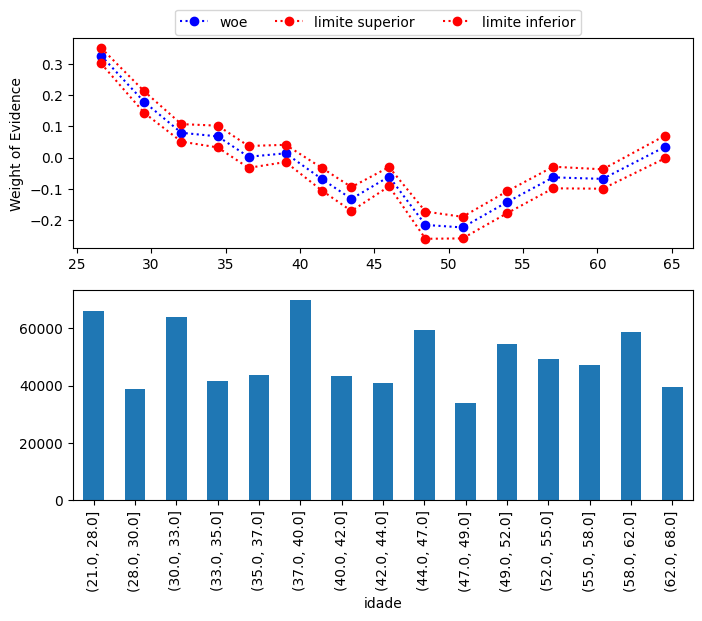

In [44]:
biv_continua('idade', 15, df)

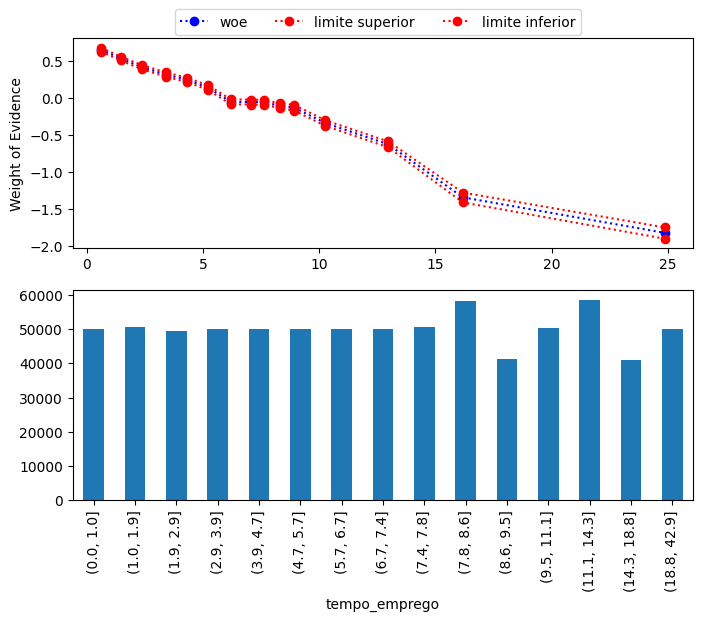

In [45]:
biv_continua('tempo_emprego', 15, df)

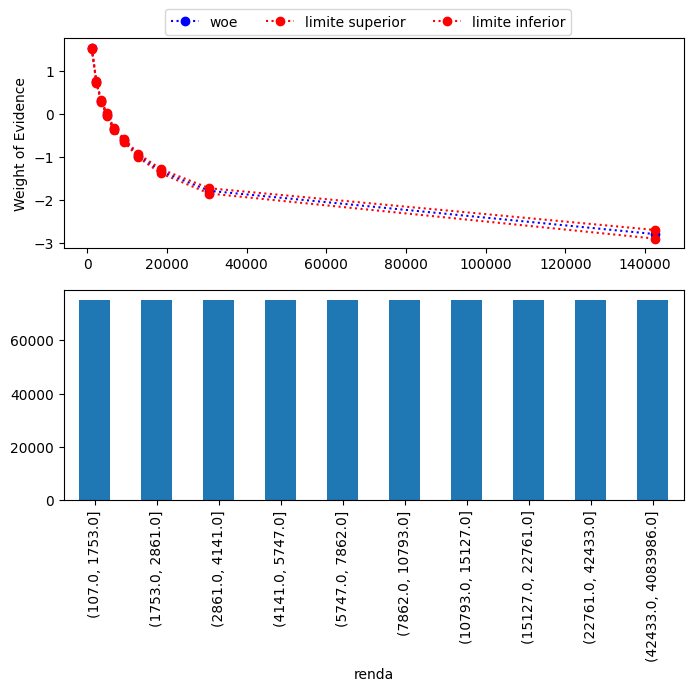

In [46]:
biv_continua('renda', 10, df)

In [47]:
' + '.join(list(df_train.columns))

'sexo + posse_de_veiculo + posse_de_imovel + qtd_filhos + tipo_renda + educacao + estado_civil + tipo_residencia + idade + tempo_emprego + qt_pessoas_residencia + renda + mau + qtd_filhos_bin + idade_bin + tempo_emprego_bin + qt_pessoas_residencia_bin + renda_bin + sexo_outlier + posse_de_veiculo_outlier + posse_de_imovel_outlier + qtd_filhos_outlier + tipo_renda_outlier + educacao_outlier + estado_civil_outlier + tipo_residencia_outlier + idade_outlier + tempo_emprego_bin_outlier + qt_pessoas_residencia_outlier + renda_bin_outlier'

In [48]:
formula = '''
mau ~ sexo + posse_de_veiculo + posse_de_imovel + qtd_filhos + 
tipo_renda + educacao + estado_civil + tipo_residencia + idade + 
tempo_emprego + qt_pessoas_residencia + renda
'''

In [49]:
logistic_regression = smf.glm(formula, data=df_train, family=sm.families.Binomial())
logistic_regression = logistic_regression.fit()

In [50]:
logistic_regression.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                      Generalized Linear Model Regression Results                      
=======================================================================================
Dep. Variable:     ['mau[False]', 'mau[True]']   No. Observations:               600000
Model:                                     GLM   Df Residuals:                   599977
Model Family:                         Binomial   Df Model:                           22
Link Function:                           Logit   Scale:                          1.0000
Method:                                   IRLS   Log-Likelihood:            -1.2498e+05
Date:                         Thu, 18 Jul 2024   Deviance:                   2.4995e+05
Time:                                 10:16:16   Pearson chi2:                 1.36e+16
No. Iterations:                             10   Pseudo R-squ. (CS):            0.04230
Covariance Type:                     nonrobust                                         
====================================================================================================
                                       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercept                            1.1331      0.183      6.188      0.000       0.774       1.492
sexo[T.M]                            0.1179      0.013      8.978      0.000       0.092       0.144
posse_de_veiculo[T.S]               -0.0319      0.012     -2.579      0.010      -0.056      -0.008
posse_de_imovel[T.S]                 0.0864      0.012      7.322      0.000       0.063       0.110
tipo_renda[T.Empresário]             0.0517      0.014      3.697      0.000       0.024       0.079
tipo_renda[T.Pensionista]           -0.0397      0.020     -1.980      0.048      -0.079      -0.000
tipo_renda[T.Servidor público]       0.0439      0.023      1.892      0.059      -0.002       0.089
educacao[T.Médio]                    0.0416      0.049      0.855      0.392      -0.054       0.137
educacao[T.Superior completo]        0.1057      0.050      2.128      0.033       0.008       0.203
educacao[T.Superior incompleto]      0.0961      0.056      1.728      0.084      -0.013       0.205
estado_civil[T.Separado]             0.0424      0.087      0.485      0.628      -0.129       0.214
estado_civil[T.Solteiro]             0.0807      0.086      0.943      0.346      -0.087       0.249
estado_civil[T.União]               -0.0501      0.020     -2.461      0.014      -0.090      -0.010
estado_civil[T.Viúvo]                0.1051      0.089      1.176      0.240      -0.070       0.280
tipo_residencia[T.Casa]              0.0891      0.044      2.029      0.042       0.003       0.175
tipo_residencia[T.Com os pais]       0.0782      0.049      1.581      0.114      -0.019       0.175
tipo_residencia[T.Estúdio]           0.0323      0.082      0.393      0.695      -0.129       0.193
tipo_residencia[T.Governamental]     0.0941      0.053      1.768      0.077      -0.010       0.198
qtd_filhos                          -0.0832      0.085     -0.982      0.326      -0.249       0.083
idade                                0.0012      0.001      1.784      0.074      -0.000       0.003
tempo_emprego                        0.0291      0.002     18.150      0.000       0.026       0.032
qt_pessoas_residencia                0.0813      0.084      0.963      0.336      -0.084       0.247
renda                                0.0001   1.08e-06     94.630      0.000    9.98e-05       0.000
====================================================================================================
"""

In [51]:
metadados.sort_values(by='IV', ascending=False)

,dtype,ausentes,unicos,papel,IV
renda,float64,0,142419,covariavel,1.0686277222
tempo_emprego,float64,0,3004,covariavel,0.2461619751
idade,int64,0,47,covariavel,0.0179684229
posse_de_imovel,object,0,2,covariavel,0.0096931156
tipo_renda,object,0,5,covariavel,0.0093600611
educacao,object,0,5,covariavel,0.0035465188
tipo_residencia,object,0,6,covariavel,0.0030445739
sexo,object,0,2,covariavel,0.0021846961
qt_pessoas_residencia,float64,0,9,covariavel,0.0013458925
estado_civil,object,0,5,covariavel,0.0011256343


In [52]:
formula = 'mau ~ tempo_emprego + renda'

In [53]:
logistic_regression = smf.glm(formula, data=df_train, family=sm.families.Binomial())
logistic_regression = logistic_regression.fit()

In [54]:
logistic_regression.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                      Generalized Linear Model Regression Results                      
=======================================================================================
Dep. Variable:     ['mau[False]', 'mau[True]']   No. Observations:               600000
Model:                                     GLM   Df Residuals:                   599997
Model Family:                         Binomial   Df Model:                            2
Link Function:                           Logit   Scale:                          1.0000
Method:                                   IRLS   Log-Likelihood:            -1.2507e+05
Date:                         Thu, 18 Jul 2024   Deviance:                   2.5014e+05
Time:                                 10:16:18   Pearson chi2:                 1.37e+16
No. Iterations:                             10   Pseudo R-squ. (CS):            0.04200
Covariance Type:                     nonrobust                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         1.5775      0.010    151.194      0.000       1.557       1.598
tempo_emprego     0.0264      0.001     18.231      0.000       0.024       0.029
renda             0.0001   1.07e-06     97.402      0.000       0.000       0.000
=================================================================================
"""

## Avaliação do modelo

Avalie o poder discriminante do modelo pelo menos avaliando acurácia, KS e Gini.

Avalie estas métricas nas bases de desenvolvimento e *out of time*.

Train

In [55]:
df_train['predict'] = logistic_regression.predict(df_train)
df_train['predict_bin'] = pd.cut(x = df_train['predict'], bins = 5)
group_predict_bin = df_train.groupby(by = 'predict_bin', observed=True)
predict_mean = group_predict_bin['predict'].mean()
mau_mean = group_predict_bin['mau'].mean()
quality = pd.concat([predict_mean, mau_mean], axis = 1)

<Axes: xlabel='predict_bin'>

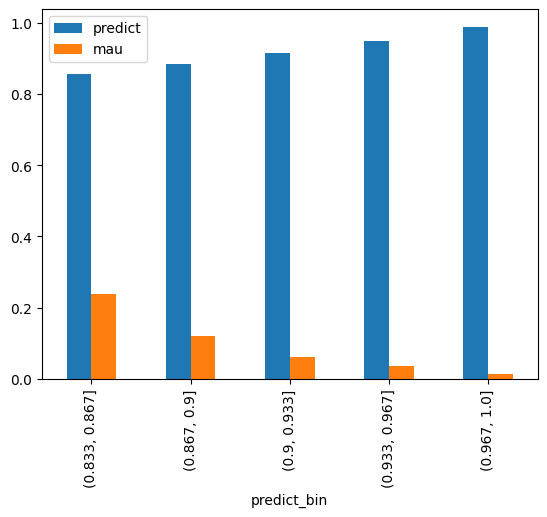

In [56]:
quality.plot(kind = 'bar')

<Axes: xlabel='predict_bin'>

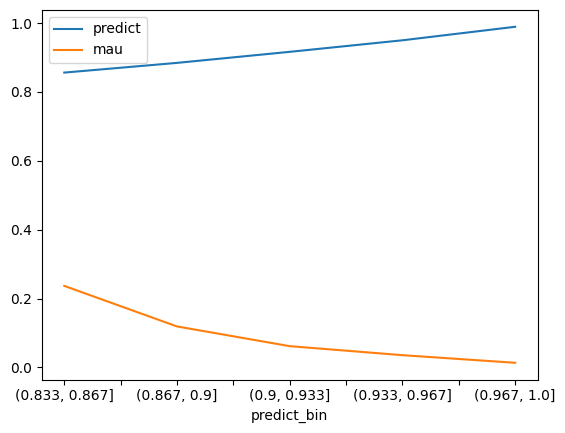

In [57]:
quality.plot()

In [58]:
mean_absolute_deviation = (((quality['predict'] - quality['mau']) ** 2) ** (1/2)).mean()
mean_absolute_deviation

0.8257885988728167

In [59]:
accuracy = metrics.accuracy_score(df_train['mau'], df_train['predict'] > 0.5)
print('Acurácia: {0:.2f}%'.format(accuracy * 100))

#AUC
fpr, tpr, thresholds = metrics.roc_curve(df_train['mau'], df_train['predict'])
auc_ = metrics.auc(fpr, tpr)

#Gini
gini = 2 * auc_ - 1

#KS
ks = ks_2samp(df_train.loc[df_train['mau'] == 1, 'predict'], df_train.loc[df_train['mau'] != 1, 'predict']).statistic

print('KS: {0:.2f}% \nAUC: {1:.2f}% \nGINI: {2:.2f}%'.format(ks * 100, auc_ * 100, gini * 100))

Acurácia: 6.11%
KS: 39.13% 
AUC: 23.53% 
GINI: -52.94%


Validation

In [60]:
df_validation['predict'] = logistic_regression.predict(df_validation)
df_validation['predict_bin'] = pd.cut(x = df_validation['predict'], bins = 5)
group_predict_bin = df_validation.groupby(by = 'predict_bin', observed=True)
predict_mean = group_predict_bin['predict'].mean()
mau_mean = group_predict_bin['mau'].mean()
quality = pd.concat([predict_mean, mau_mean], axis = 1)

<Axes: xlabel='predict_bin'>

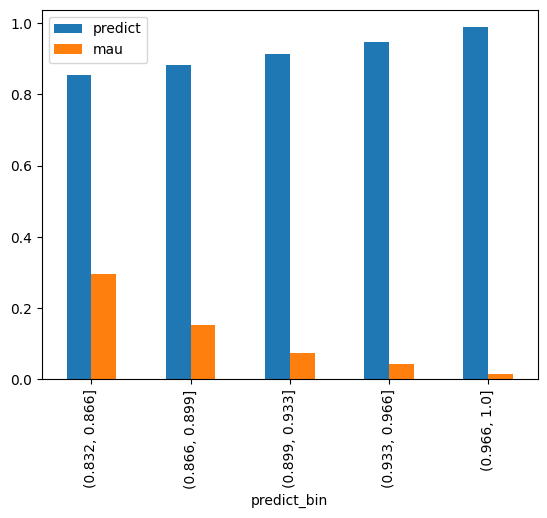

In [61]:
quality.plot(kind = 'bar')

<Axes: xlabel='predict_bin'>

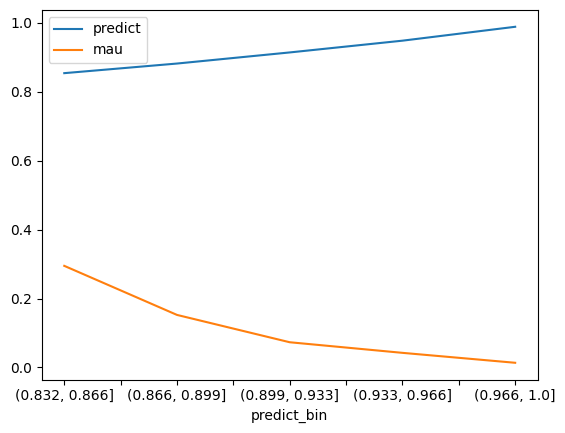

In [62]:
quality.plot()

In [63]:
mean_absolute_deviation = (((quality['predict'] - quality['mau']) ** 2) ** (1/2)).mean()
mean_absolute_deviation

0.8018629354064266

In [64]:
accuracy = metrics.accuracy_score(df_validation['mau'], df_validation['predict'] > 0.5)
print('Acurácia: {0:.2f}%'.format(accuracy * 100))

#AUC
fpr, tpr, thresholds = metrics.roc_curve(df_validation['mau'], df_validation['predict'])
auc_ = metrics.auc(fpr, tpr)

#Gini
gini = 2 * auc_ - 1

#KS
ks = ks_2samp(df_validation.loc[df_validation['mau'] == 1, 'predict'], df_validation.loc[df_validation['mau'] != 1, 'predict']).statistic

print('KS: {0:.2f}% \nAUC: {1:.2f}% \nGINI: {2:.2f}%'.format(ks * 100, auc_ * 100, gini * 100))

Acurácia: 14.67%
KS: 32.65% 
AUC: 27.56% 
GINI: -44.89%


## Criar um pipeline utilizando o sklearn pipeline 

In [65]:
df = pd.read_feather('credit_scoring.ftr')
df.head()

,data_ref,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,mau
0,2015-01-01,5733,F,N,N,0,Empresário,Médio,Solteiro,Casa,43,6.8739726027,1.0,2515.39,False
1,2015-01-01,727,F,S,S,0,Assalariado,Médio,Casado,Casa,35,4.5260273973,2.0,3180.19,False
2,2015-01-01,6374,F,N,N,2,Assalariado,Médio,Casado,Casa,31,0.2438356164,4.0,1582.29,False
3,2015-01-01,9566,F,N,N,0,Assalariado,Médio,Casado,Casa,54,12.7726027397,2.0,13721.17,False
4,2015-01-01,9502,F,S,N,0,Assalariado,Superior incompleto,Solteiro,Casa,31,8.4328767123,1.0,2891.08,False


## Pré processamento

In [66]:
def initial_treatment(dataframe=None):

    dataframe = dataframe.copy()
    
    dataframe['sexo'] = dataframe['sexo'].astype('category')
    dataframe['posse_de_veiculo'] = dataframe['posse_de_veiculo'].astype('bool')
    dataframe['posse_de_imovel'] = dataframe['posse_de_imovel'].astype('bool')
    dataframe['qtd_filhos'] = dataframe['qtd_filhos'].astype('int8')
    dataframe['tipo_renda'] = dataframe['tipo_renda'].astype('category')
    dataframe['educacao'] = dataframe['educacao'].astype('category')
    dataframe['estado_civil'] = dataframe['estado_civil'].astype('category')
    dataframe['tipo_residencia'] = dataframe['tipo_residencia'].astype('category')
    dataframe['idade'] = dataframe['idade'].astype('int8')
    dataframe['tempo_emprego'] = dataframe['tempo_emprego'].astype('float32')
    dataframe['qt_pessoas_residencia'] = dataframe['qt_pessoas_residencia'].astype('int8')
    
    return dataframe

### Substituição de nulos (nans)

Existe nulos na base? é dado numérico ou categórico? qual o valor de substituição? média? valor mais frequente? etc

In [67]:
def missing_values(dataframe=None, columns=None, methods=None):
    
    # dataframe = dataframe.copy()
        
    for column, method in zip(columns, methods):
        if dataframe[column].isna().sum():
            
            _call = getattr(
                dataframe[dataframe[column].isna() == False][column], 
                method
            )
            
            value = _call()
            
            dataframe.loc[dataframe[column].isna(), column] = value
            
    return dataframe

In [68]:
def missing_treatment(dataframe=None):
    
    dataframe = dataframe.copy()
    
    return missing_values(dataframe=dataframe, columns=['idade', 'tempo_emprego', 'renda'], methods=['mode', 'mean', 'median'])

### Remoção de outliers

Como identificar outlier? Substituir o outlier por algum valor? Remover a linha?

In [69]:
def outlier_detect(dataframe=None, column=None, cumulate=0.99):
    
    _bin_count = dataframe[column].value_counts()
    _bin_count.sort_values(ascending = False, inplace = True)
    _bin_count = _bin_count.to_frame()
    _bin_count['freq'] = _bin_count / _bin_count.sum()
    _bin_count['freq_cum'] = _bin_count['freq'].cumsum()

    _bin_interval = _bin_count[_bin_count['freq_cum'] >= cumulate].iloc[1:]

    column_outliers = pd.Series(data=False, index=dataframe.index, name=column)

    if _bin_interval.empty:
        return column_outliers
    
    column_outliers[dataframe[column].isin(_bin_interval.index)] = True

    return column_outliers

In [70]:
def outlier_treatment(dataframe=None):
    
    dataframe = dataframe.copy()
    
    dataframe['tempo_emprego_bin'] = round(dataframe['tempo_emprego'], ndigits=0)
    dataframe['renda_bin'] = round(dataframe['renda'], ndigits=-2)
    
    columns_outliers = {
        'sexo':'sexo', 
        'posse_de_veiculo':'posse_de_veiculo', 
        'posse_de_imovel':'posse_de_imovel', 
        'qtd_filhos':'qtd_filhos', 
        'tipo_renda':'tipo_renda', 
        'educacao':'educacao', 
        'estado_civil':'estado_civil', 
        'tipo_residencia':'tipo_residencia', 
        'idade':'idade', 
        'tempo_emprego_bin':'tempo_emprego', 
        'qt_pessoas_residencia':'qt_pessoas_residencia', 
        'renda_bin':'renda'
    }
    
    columns = list(columns_outliers.keys())

    dataframe_outliers = pd.DataFrame()
    for column in columns:
        dataframe_outliers[column] = outlier_detect(dataframe=dataframe, column=column)
    
    _outliers = pd.concat(objs=[dataframe, dataframe_outliers.add_suffix(suffix='_outlier', axis=1)], axis=1)
    
    outliers_count = (dataframe_outliers.sum() > 0)
    columns = outliers_count[outliers_count == True].index

    for column in columns:
        column_outlier_true = _outliers[f'{column}_outlier'].value_counts()[True]

        sample = dataframe[_outliers[f'{column}_outlier'] == False][columns_outliers[column]].sample(
            n = column_outlier_true,
            replace = True,
            random_state = 100
        )

        condition = (_outliers[f'{column}_outlier'] == True)

        dataframe.loc[condition, columns_outliers[column]] = sample.values
        
    dataframe.drop(labels=['tempo_emprego_bin', 'renda_bin'], axis=1, inplace=True)
    
    return dataframe

### Seleção de variáveis

Qual tipo de técnica? Boruta? Feature importance? 

In [71]:
def IV(variavel, resposta):
    tab = pd.crosstab(variavel, resposta, margins=True, margins_name='total')

    rótulo_evento = tab.columns[0]
    rótulo_nao_evento = tab.columns[1]

    tab['pct_evento'] = tab[rótulo_evento]/tab.loc['total',rótulo_evento]
    tab['ep'] = tab[rótulo_evento]/tab.loc['total',rótulo_evento]
    
    tab['pct_nao_evento'] = tab[rótulo_nao_evento]/tab.loc['total',rótulo_nao_evento]
    tab['woe'] = np.log(tab.pct_evento/tab.pct_nao_evento)
    tab['iv_parcial'] = (tab.pct_evento - tab.pct_nao_evento)*tab.woe
    return tab['iv_parcial'].sum()

In [72]:
def information_value(dataframe=None):
    
    dataframe = dataframe.copy()
    
    metadados = pd.DataFrame(dataframe.dtypes, columns=['dtype'])
    metadados['ausentes'] = dataframe.isna().sum()
    metadados['unicos'] = dataframe.nunique()
    metadados['papel'] = 'covariavel'
    metadados.loc['mau','papel'] = 'resposta'
    
    for var in metadados[metadados.papel=='covariavel'].index:
        if  (metadados.loc[var, 'unicos'] > 6):
            metadados.loc[var, 'IV'] = IV(pd.qcut(df[var], 5, duplicates='drop'), df.mau)
        else: 
            metadados.loc[var, 'IV'] = IV(df[var], df.mau)
    
    filter = list(metadados[metadados['IV'] >= 0.025].index.values)
    
    return dataframe[filter]

### Redução de dimensionalidade (PCA)

Aplicar PCA para reduzir a dimensionalidade para 5

In [73]:
scaler = StandardScaler()
pca = PCA(n_components=2)

### Criação de dummies

Aplicar o get_dummies() ou onehotencoder() para transformar colunas catégoricas do dataframe em colunas de 0 e 1. 
- sexo
- posse_de_veiculo
- posse_de_imovel
- tipo_renda
- educacao
- estado_civil
- tipo_residencia

In [74]:
def get_dummies_treatment(dataframe=None):
    
    dataframe = dataframe.copy()
    
    return pd.get_dummies(dataframe)

In [75]:
logistic = LogisticRegression(max_iter=200)

### Pipeline 

Crie um pipeline contendo essas funções.

preprocessamento()
- substituicao de nulos
- remoção outliers
- PCA
- Criação de dummy de pelo menos 1 variável (posse_de_veiculo)

In [76]:
df.drop(labels='index', axis=1, inplace=True)

df.set_index(keys=[df.index, pd.to_datetime(df['data_ref'])], inplace=True)
df.drop(labels='data_ref', axis=1, inplace=True)
df.sort_index(level=1, inplace=True)

In [77]:
end_date_validation = df[-1:].index[0][1]
start_date_validation = end_date_validation - pd.DateOffset(months=2)

start_date_train = df[:1].index[0][1]
end_date_train = (start_date_validation - pd.DateOffset(days=1)) - pd.offsets.MonthBegin(1)

print(f'Train start date: {start_date_train}')
print(f'Train end date: {end_date_train}')
print(f'Test start date: {start_date_validation}')
print(f'Test end date: {end_date_validation}')

df_train = df.loc[(slice(None), slice(start_date_train, end_date_train)), :].copy()
df_validation = df.loc[(slice(None), slice(start_date_validation, end_date_validation)), :].copy()

Train start date: 2015-01-01 00:00:00
Train end date: 2015-12-01 00:00:00
Test start date: 2016-01-01 00:00:00
Test end date: 2016-03-01 00:00:00


In [78]:
X = df_train.drop('mau', axis=1)
y = df_train['mau']

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=100)

Pipeline

In [79]:
initial = FunctionTransformer(initial_treatment)
missing = FunctionTransformer(missing_treatment)
outlier = FunctionTransformer(outlier_treatment)
informationvalue = FunctionTransformer(information_value)
dummies = FunctionTransformer(get_dummies_treatment)

pipeline = Pipeline(
    steps=[
        ('initial', initial),
        ('missing', missing),
        ('outlier', outlier),
        ('informationvalue', informationvalue),
        ('dummies', dummies),
        ('scaler', scaler), 
        ('pca', pca),
        ('logistic', logistic)
    ]
)

In [80]:
pipeline.named_steps

{'initial': FunctionTransformer(func=<function initial_treatment at 0x00000198096C8B80>),
 'missing': FunctionTransformer(func=<function missing_treatment at 0x0000019802C072E0>),
 'outlier': FunctionTransformer(func=<function outlier_treatment at 0x000001980BD07880>),
 'informationvalue': FunctionTransformer(func=<function information_value at 0x0000019869DC2AC0>),
 'dummies': FunctionTransformer(func=<function get_dummies_treatment at 0x0000019802C58220>),
 'scaler': StandardScaler(),
 'pca': PCA(n_components=2),
 'logistic': LogisticRegression(max_iter=200)}

Treino

In [81]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('initial',
                 FunctionTransformer(func=<function initial_treatment at 0x00000198096C8B80>)),
                ('missing',
                 FunctionTransformer(func=<function missing_treatment at 0x0000019802C072E0>)),
                ('outlier',
                 FunctionTransformer(func=<function outlier_treatment at 0x000001980BD07880>)),
                ('informationvalue',
                 FunctionTransformer(func=<function information_value at 0x0000019869DC2AC0>)),
                ('dummies',
                 FunctionTransformer(func=<function get_dummies_treatment at 0x0000019802C58220>)),
                ('scaler', StandardScaler()), ('pca', PCA(n_components=2)),
                ('logistic', LogisticRegression(max_iter=200))])

In [82]:
pipeline.predict(X_train)

array([False, False, False, ..., False, False, False])

Teste

In [83]:
pipeline.predict(X_test)

array([False, False, False, ..., False, False, False])

### Treinar um modelo de regressão logistica com o resultado

Modelo treinado dentro do pipeline

### Salvar o pickle file do modelo treinado

In [84]:
file_name = 'model/model_final.pkl'
pickle.dump(pipeline, open(file_name, 'wb'))

# Pycaret na base de dados 

Utilize o pycaret para pre processar os dados e rodar o modelo **lightgbm**. Faça todos os passos a passos da aula e gere os gráficos finais. E o pipeline de toda a transformação.



In [85]:
import numpy as np
import pandas as pd

from pycaret.classification import *
from pycaret.utils.generic import check_metric

In [86]:
df = pd.read_feather('credit_scoring.ftr')
df.head()

,data_ref,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,mau
0,2015-01-01,5733,F,N,N,0,Empresário,Médio,Solteiro,Casa,43,6.8739726027,1.0,2515.39,False
1,2015-01-01,727,F,S,S,0,Assalariado,Médio,Casado,Casa,35,4.5260273973,2.0,3180.19,False
2,2015-01-01,6374,F,N,N,2,Assalariado,Médio,Casado,Casa,31,0.2438356164,4.0,1582.29,False
3,2015-01-01,9566,F,N,N,0,Assalariado,Médio,Casado,Casa,54,12.7726027397,2.0,13721.17,False
4,2015-01-01,9502,F,S,N,0,Assalariado,Superior incompleto,Solteiro,Casa,31,8.4328767123,1.0,2891.08,False


In [87]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750000 entries, 0 to 749999
Data columns (total 15 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   data_ref               750000 non-null  datetime64[ns]
 1   index                  750000 non-null  int64         
 2   sexo                   750000 non-null  object        
 3   posse_de_veiculo       750000 non-null  object        
 4   posse_de_imovel        750000 non-null  object        
 5   qtd_filhos             750000 non-null  int64         
 6   tipo_renda             750000 non-null  object        
 7   educacao               750000 non-null  object        
 8   estado_civil           750000 non-null  object        
 9   tipo_residencia        750000 non-null  object        
 10  idade                  750000 non-null  int64         
 11  tempo_emprego          624043 non-null  float64       
 12  qt_pessoas_residencia  750000 non-null  floa

In [88]:
df.drop(labels='index', axis=1, inplace=True)

In [89]:
df.set_index(keys=[df.index, pd.to_datetime(df['data_ref'])], inplace=True)
df.drop(labels='data_ref', axis=1, inplace=True)
df.sort_index(level=1, inplace=True)

In [90]:
for column in df.columns:
    print(f'{column} | {df[column].nunique()} | {df[column].unique()}')

sexo | 2 | ['F' 'M']
posse_de_veiculo | 2 | ['N' 'S']
posse_de_imovel | 2 | ['N' 'S']
qtd_filhos | 8 | [ 0  2  1  3  4  7 14  5]
tipo_renda | 5 | ['Empresário' 'Assalariado' 'Servidor público' 'Pensionista' 'Bolsista']
educacao | 5 | ['Médio' 'Superior incompleto' 'Superior completo' 'Fundamental'
 'Pós graduação']
estado_civil | 5 | ['Solteiro' 'Casado' 'União' 'Separado' 'Viúvo']
tipo_residencia | 6 | ['Casa' 'Com os pais' 'Aluguel' 'Comunitário' 'Governamental' 'Estúdio']
idade | 47 | [43 35 31 54 45 38 40 60 66 47 57 65 52 27 41 44 49 26 37 36 42 53 64 62
 59 33 39 56 34 22 48 61 29 55 32 28 25 24 58 30 50 46 63 51 68 67 23]
tempo_emprego | 3004 | [ 6.8739726   4.5260274   0.24383562 ...  3.26575342 15.19178082
  3.07123288]
qt_pessoas_residencia | 9 | [ 1.  2.  4.  3.  5.  6.  9. 15.  7.]
renda | 142419 | [ 2515.39  3180.19  1582.29 ...  6046.34 27362.96  3607.09]
mau | 2 | [False  True]


In [91]:
df['sexo'] = df['sexo'].astype('category')
df['posse_de_veiculo'] = df['posse_de_veiculo'].astype('bool')
df['posse_de_imovel'] = df['posse_de_imovel'].astype('bool')
df['qtd_filhos'] = df['qtd_filhos'].astype('int8')
df['tipo_renda'] = df['tipo_renda'].astype('category')
df['educacao'] = df['educacao'].astype('category')
df['estado_civil'] = df['estado_civil'].astype('category')
df['tipo_residencia'] = df['tipo_residencia'].astype('category')
df['idade'] = df['idade'].astype('int8')
df['tempo_emprego'] = df['tempo_emprego'].astype('float32')
df['qt_pessoas_residencia'] = df['qt_pessoas_residencia'].astype('int8')

In [92]:
df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 750000 entries, (0, Timestamp('2015-01-01 00:00:00')) to (749999, Timestamp('2016-03-01 00:00:00'))
Data columns (total 13 columns):
 #   Column                 Non-Null Count   Dtype   
---  ------                 --------------   -----   
 0   sexo                   750000 non-null  category
 1   posse_de_veiculo       750000 non-null  bool    
 2   posse_de_imovel        750000 non-null  bool    
 3   qtd_filhos             750000 non-null  int8    
 4   tipo_renda             750000 non-null  category
 5   educacao               750000 non-null  category
 6   estado_civil           750000 non-null  category
 7   tipo_residencia        750000 non-null  category
 8   idade                  750000 non-null  int8    
 9   tempo_emprego          624043 non-null  float32 
 10  qt_pessoas_residencia  750000 non-null  int8    
 11  renda                  750000 non-null  float64 
 12  mau                    750000 non-null  bool    
dtypes:

In [93]:
df.describe()

,qtd_filhos,idade,tempo_emprego,qt_pessoas_residencia,renda
count,750000.0000000000,750000.0000000000,624043.0000000000,750000.0000000000,7.5000000000e+05
mean,0.4332506667,43.8047333333,7.7485742569,2.2122413333,2.3238544747e+04
std,0.7393789660,11.2298678714,6.6874547005,0.9034283063,7.9106013795e+04
min,0.0000000000,22.0000000000,0.1178082228,1.0000000000,1.0767000000e+02
25%,0.0000000000,34.0000000000,3.0493149757,2.0000000000,3.4677000000e+03
50%,0.0000000000,43.0000000000,6.0465755463,2.0000000000,7.8618200000e+03
75%,1.0000000000,53.0000000000,10.1835613251,3.0000000000,1.8318280000e+04
max,14.0000000000,68.0000000000,42.9068489075,15.0000000000,4.0839862200e+06


In [94]:
df['tempo_emprego'].isna().sum()

125957

In [95]:
dados = df.groupby(by='idade')['tempo_emprego'].median()
dados

idade
22     2.9616439342
23     2.9315068722
24     2.6301369667
25     3.6876711845
26     3.3506848812
27     4.4191780090
28     4.6931505203
29     4.4109587669
30     5.3287672997
31     5.2986302376
32     5.5232877731
33     4.9643836021
34     5.7671232224
35     5.0520548820
36     6.9643836021
37     6.0465755463
38     6.5863013268
39     6.7671232224
40     6.7479453087
41     5.7589039803
42     7.2986302376
43     7.5561642647
44     6.9342465401
45     6.7863011360
46     5.5506849289
47     6.4301371574
48     6.7123289108
49     8.3671236038
50     7.5561642647
51     9.5178079605
52     8.3589038849
53     7.2136988640
54     8.8465757370
55     7.3479452133
56    10.6109590530
57     7.8410959244
58     7.4739727974
59     8.6136989594
60    14.2876710892
61     8.1369867325
62     7.6191782951
63     8.7726030350
64     7.1698632240
65     5.8821916580
66     8.3726024628
67    21.1945209503
68              NaN
Name: tempo_emprego, dtype: float32

In [96]:
for idade, tempo_emprego in dados.items():
    df.loc[(df['tempo_emprego'].isna()) & (df['idade'] == idade), 'tempo_emprego'] = tempo_emprego

In [97]:
df['tempo_emprego'].isna().sum()

855

In [98]:
df.loc[df['tempo_emprego'].isna(), 'tempo_emprego'] = df['tempo_emprego'].median()

In [99]:
df['tempo_emprego'].isna().sum()

0

In [100]:
end_date_validation = df[-1:].index[0][1]
start_date_validation = end_date_validation - pd.DateOffset(months=2)

start_date_train = df[:1].index[0][1]
end_date_train = (start_date_validation - pd.DateOffset(days=1)) - pd.offsets.MonthBegin(1)

print(f'Train start date: {start_date_train}')
print(f'Train end date: {end_date_train}')
print(f'Test start date: {start_date_validation}')
print(f'Test end date: {end_date_validation}')

df_train = df.loc[(slice(None), slice(start_date_train, end_date_train)), :].copy()
df_validation = df.loc[(slice(None), slice(start_date_validation, end_date_validation)), :].copy()

Train start date: 2015-01-01 00:00:00
Train end date: 2015-12-01 00:00:00
Test start date: 2016-01-01 00:00:00
Test end date: 2016-03-01 00:00:00


In [101]:
experiment = setup(
    data = df_train,
    target = 'mau',
    experiment_name='credit',
    session_id=123,
    normalize=True, normalize_method='zscore',
    transformation=True, transformation_method = 'quantile',
    # fix_imbalance=True
)

,Description,Value
0,Session id,123
1,Target,mau
2,Target type,Binary
3,Original data shape,"(600000, 13)"
4,Transformed data shape,"(600000, 30)"
5,Transformed train set shape,"(420000, 30)"
6,Transformed test set shape,"(180000, 30)"
7,Numeric features,5
8,Categorical features,5
9,Preprocess,True


In [102]:
models()

,Name,Reference,Turbo
ID,,,
lr,Logistic Regression,sklearn.linear_model._logistic.LogisticRegression,True
knn,K Neighbors Classifier,sklearn.neighbors._classification.KNeighborsCl...,True
nb,Naive Bayes,sklearn.naive_bayes.GaussianNB,True
dt,Decision Tree Classifier,sklearn.tree._classes.DecisionTreeClassifier,True
svm,SVM - Linear Kernel,sklearn.linear_model._stochastic_gradient.SGDC...,True
rbfsvm,SVM - Radial Kernel,sklearn.svm._classes.SVC,False
gpc,Gaussian Process Classifier,sklearn.gaussian_process._gpc.GaussianProcessC...,False
mlp,MLP Classifier,sklearn.neural_network._multilayer_perceptron....,False
ridge,Ridge Classifier,sklearn.linear_model._ridge.RidgeClassifier,True


In [103]:
lightgbm = create_model('lightgbm')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9390,0.7644,0.0031,0.7273,0.0062,0.0057,0.0450
1,0.9388,0.7657,0.0043,0.4074,0.0085,0.0072,0.0367
2,0.9389,0.7682,0.0047,0.4444,0.0093,0.0080,0.0406
3,0.9389,0.7712,0.0082,0.5000,0.0161,0.0142,0.0580
4,0.9392,0.7633,0.0086,0.6875,0.0169,0.0155,0.0722
5,0.9389,0.7720,0.0023,0.4286,0.0047,0.0040,0.0280
6,0.9385,0.7617,0.0058,0.3191,0.0115,0.0093,0.0361
7,0.9389,0.7715,0.0058,0.4688,0.0116,0.0101,0.0470
8,0.9389,0.7715,0.0074,0.4872,0.0146,0.0128,0.0542


In [104]:
tuned_lightgbm = tune_model(lightgbm, optimize='F1', n_iter=1)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9389,0.7646,0.0000,0.0000,0.0000,0.0000,0.0000
1,0.9389,0.7653,0.0000,0.0000,0.0000,0.0000,0.0000
2,0.9389,0.7671,0.0000,0.0000,0.0000,0.0000,0.0000
3,0.9389,0.7707,0.0000,0.0000,0.0000,0.0000,0.0000
4,0.9389,0.7633,0.0000,0.0000,0.0000,0.0000,0.0000
5,0.9389,0.7699,0.0000,0.0000,0.0000,0.0000,0.0000
6,0.9389,0.7617,0.0000,0.0000,0.0000,0.0000,0.0000
7,0.9389,0.7714,0.0000,0.0000,0.0000,0.0000,0.0000
8,0.9389,0.7706,0.0000,0.0000,0.0000,0.0000,0.0000


Fitting 10 folds for each of 1 candidates, totalling 10 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


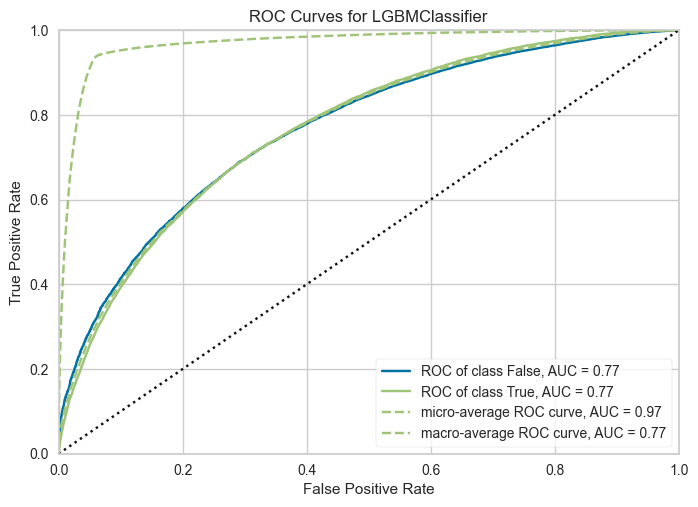

In [105]:
plot_model(tuned_lightgbm, plot = 'auc')

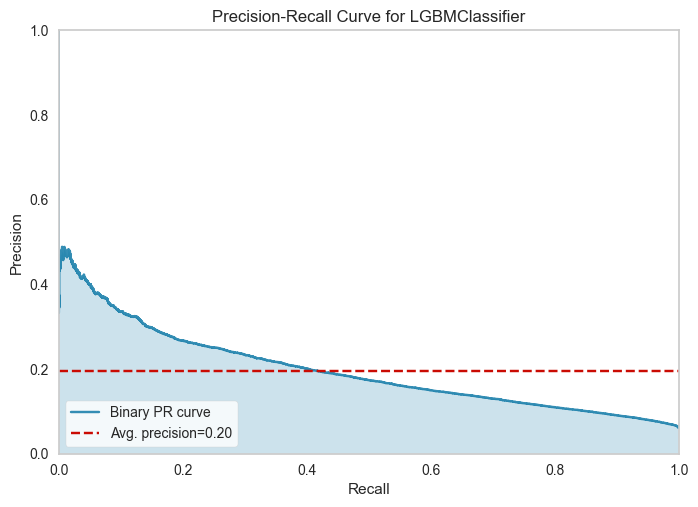

In [106]:
plot_model(tuned_lightgbm, plot = 'pr')

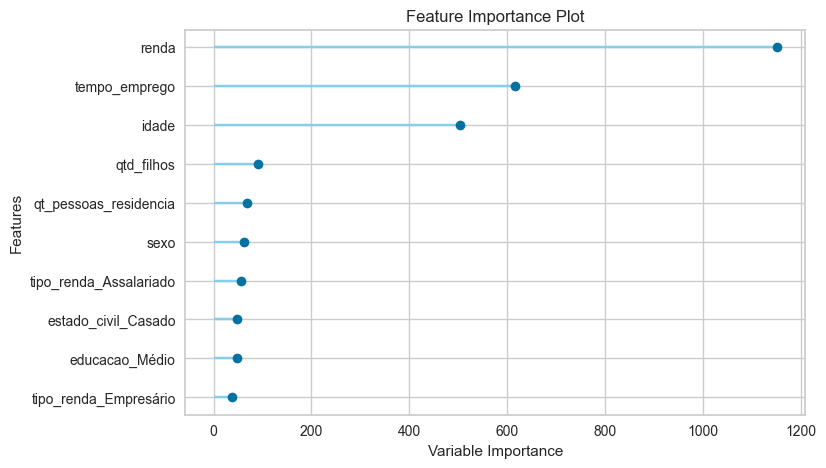

In [107]:
plot_model(tuned_lightgbm, plot='feature')

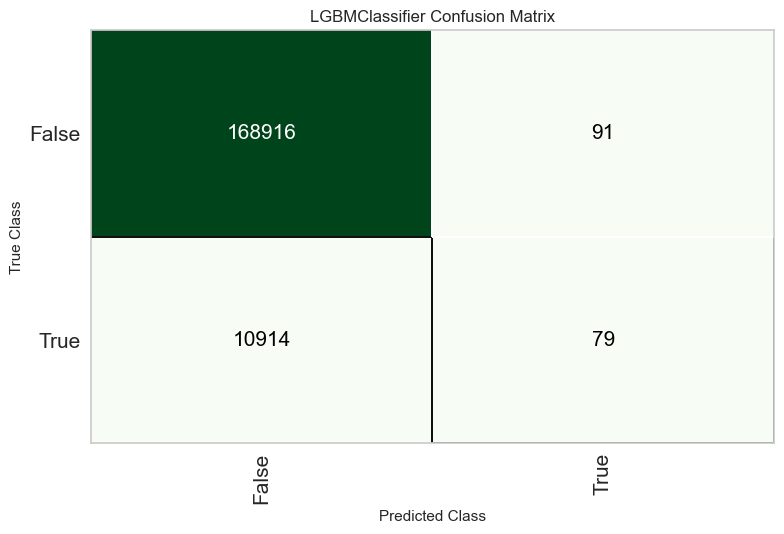

In [108]:
plot_model(tuned_lightgbm, plot='confusion_matrix')

In [109]:
# evaluate_model(tuned_lightgbm)

In [110]:
predict_model(tuned_lightgbm)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.9389,0.7681,0.0072,0.4647,0.0142,0.0123,0.0518


,,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,mau,prediction_label,prediction_score
,data_ref,,,,,,,,,,,,,,,
281252,2015-06-01,F,True,True,0,Pensionista,Médio,Viúvo,Casa,50,7.5561642647,1,9058.2197265625,False,0,0.9554
237807,2015-05-01,F,True,True,1,Assalariado,Médio,Casado,Casa,28,4.7150683403,3,9735.1796875000,False,0,0.9602
168161,2015-04-01,F,True,True,0,Pensionista,Médio,Solteiro,Casa,64,7.1698632240,1,18113.6191406250,True,0,0.9802
450377,2015-10-01,M,True,True,1,Assalariado,Médio,Casado,Aluguel,31,9.3342466354,3,15394.3300781250,False,0,0.9755
175341,2015-04-01,F,True,True,0,Servidor público,Superior completo,Casado,Casa,41,10.0109586716,2,22169.2109375000,False,0,0.9821
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
258201,2015-06-01,M,True,True,1,Assalariado,Superior completo,Casado,Casa,28,2.9616439342,3,46881.3085937500,False,0,0.9932
561969,2015-12-01,F,True,True,0,Assalariado,Superior completo,Casado,Casa,43,4.9342465401,2,1923.7600097656,False,0,0.8285
315622,2015-07-01,F,True,True,1,Assalariado,Superior completo,Solteiro,Casa,28,4.8821916580,2,28775.0996093750,False,0,0.9854


In [111]:
final_lightgbm = finalize_model(tuned_lightgbm)

In [112]:
print(final_lightgbm)

Pipeline(memory=Memory(location=None),
         steps=[('numerical_imputer',
                 TransformerWrapper(exclude=None,
                                    include=['qtd_filhos', 'idade',
                                             'tempo_emprego',
                                             'qt_pessoas_residencia', 'renda'],
                                    transformer=SimpleImputer(add_indicator=False,
                                                              copy=True,
                                                              fill_value=None,
                                                              keep_empty_features=False,
                                                              missing_values=nan,
                                                              strategy='mean'))),
                ('categorical_imputer',
                 TransformerWra...
                 LGBMClassifier(boosting_type='gbdt', class_weight=None,
                           

In [113]:
validation_predictions = predict_model(final_lightgbm, data=df_validation)
validation_predictions.head()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.8533,0.7375,0.0165,0.4939,0.0320,0.0227,0.0690


,,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,mau,prediction_label,prediction_score
,data_ref,,,,,,,,,,,,,,,
600000,2016-01-01,F,True,True,2,Assalariado,Superior completo,Casado,Casa,38,7.3835616112,4,2969.4899902344,True,0,0.8810
600001,2016-01-01,F,True,True,0,Assalariado,Médio,Casado,Casa,55,8.4712324142,2,6278.3701171875,False,0,0.9463
600002,2016-01-01,M,True,True,1,Assalariado,Médio,União,Casa,39,8.8849315643,3,14010.1796875000,False,0,0.9694
600003,2016-01-01,F,True,True,1,Assalariado,Médio,União,Com os pais,31,1.7945204973,3,2875.8100585938,False,0,0.8758
600004,2016-01-01,M,True,True,0,Assalariado,Médio,Casado,Casa,27,7.0191779137,2,2737.1899414062,False,0,0.8766


In [114]:
validation_predictions.dtypes

sexo                     category
posse_de_veiculo             bool
posse_de_imovel              bool
qtd_filhos                   int8
tipo_renda               category
educacao                 category
estado_civil             category
tipo_residencia          category
idade                        int8
tempo_emprego             float32
qt_pessoas_residencia        int8
renda                     float32
mau                          bool
prediction_label            int32
prediction_score          float64
dtype: object

In [115]:
validation_predictions['prediction_label'] = validation_predictions['prediction_label'].astype('bool')

In [116]:
check_metric(validation_predictions['mau'], validation_predictions['prediction_label'], metric='Accuracy')

0.8533

### Salvar o arquivo do modelo treinado

In [117]:
save_model(final_lightgbm,'Final Light GBM Model Jul2024')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('numerical_imputer',
                  TransformerWrapper(exclude=None,
                                     include=['qtd_filhos', 'idade',
                                              'tempo_emprego',
                                              'qt_pessoas_residencia', 'renda'],
                                     transformer=SimpleImputer(add_indicator=False,
                                                               copy=True,
                                                               fill_value=None,
                                                               keep_empty_features=False,
                                                               missing_values=nan,
                                                               strategy='mean'))),
                 ('categorical_imputer',
                  TransformerWra...
                  LGBMClassifier(boosting_type='gbdt', class_weight=None,
            

# Projeto Final

1. Subir no GITHUB todos os jupyter notebooks/códigos que você desenvolveu nesse ultimo módulo
1. Gerar um arquivo python (.py) com todas as funções necessárias para rodar no streamlit a escoragem do arquivo de treino
    - Criar um .py
    - Criar um carregador de csv no streamlit 
    - Subir um csv no streamlit 
    - Criar um pipeline de pré processamento dos dados
    - Utilizar o modelo treinado para escorar a base 
        - nome_arquivo = 'model_final.pkl'
1. Gravar um vídeo da tela do streamlit em funcionamento (usando o próprio streamlit (temos aula disso) ou qlqr outra forma de gravação).
1. Subir no Github o vídeo de funcionamento da ferramenta como README.md.
1. Subir no Github os códigos desenvolvidos. 
1. Enviar links do github para o tutor corrigir.